## Rotatividade de Pessoal (Turnover): Análise e Predição

<img src= "../imagens/turnover01.jpg"  width="600" align="left">

---

### 1 - Problema:

**Rotatividade de Pessoal** (Turnover) nas empresas é uma questão complexa, tanto pela implicação financeira da rotatividade em si, quanto pela perda de capital intelectual e talentos, além do impacto da falta do profissional na rotina da empresa.
Em cenários mais complicados podem surgir dificuldades como falta de oferta do profissional no mercado, encontrar o perfil adequado à cultura da Empresa e/ou especificidades da função, dos projetos da Empresa ou da experiência requerida do colaborador, etc.

Em um cenário real é fundamental **conhecer o contexto de negócio da empresa** para apoiar a análise dos dados e usar como referência na busca de informações complementares que enriqueçam o entendimento do problema: em qual o **segmento atua**? É uma **empresa global**? Qual o nível de especialização da mão de obra? Qual o comportamento de turnover nos concorrentes?

#### 1.1 - Impactos do Turnover

<img src= "../imagens/turnover03.png"  alt="Impacto financeiro do Turnover" width="9%" align="left" style="margin:10px 10px 10px 10px">

Os custos do processo de desligamento são altos e de natureza direta ou indireta*, mas além da demissão (encargos, saldos de valores devidos, FGTS e eventualmente questões trabalhistas), a admissão de novos funcionários (recrutamento, seleção, treinamento, passagem de conhecimento específico de processos e ferramentas), assim como a sua manutenção envolve gastos relevantes, portanto minimizar esse efeito com novas políticas, fornecer uma maneira de prever quando funcionários estiverem prestes a deixar a empresa e evitar esse desembolso é de grande interesse.


\*Custos ***Indiretos*** relacionados à **ausência do funcionário antigo** ou a **contratação do novo**, como:
- Hora extra de funcionários da equipe em função do cargo vago;
- Horas de ausência do novo funcionário sendo treinado ou em integração;
- Dimuição de produtividade da equipe; etc.

Não obstante aos impactos financeiros, impactos de ordem social também ocorrem quando a rotatividade é alta e afetam sentimentos como os de bem estar, motivação e interferem em como as equipes se organizam para manter sua performace.

#### 1.2 - Objetivo da Análise e da Predição

Como já foi mencionado antes, existe um considerável **impacto financeiro** e um reflexo direto nas **operações da empresa** em relação à rotatividade de pessoal, sendo uma questão que sobrecarrega a Gestão de Pessoas (GP) e causa desconforto no setor devido ao fato de não haver condições e/ou tempo hábil para renegociar a decisão do colaborador. Assim, prever esse fato pode aliviar as dores da empresa ao **prevenir a saída do colaborador ou pelo menos prepar a empresa para o impacto a ser gerado**.

Mas, além da **predição**, a **análise** dos dados disponíveis pode ser de grande utilidade na definição de medidas e políticas necessárias para reverter ou minimizar seus efeitos, assim como a criação de programas de recompensa visando a retenção de pessoal com base em descobertas a partir de perguntas levantadas com a observação dos dados.

### 2 - Estratégias e Soluções

Para prever a possibilidade de um colaborador deixar a empresa, testaremos alguns algorítmos de classificação que irão gerar os modelos preditivos, embora não seja apenas a seleção de algorítimos que mostre qual a melhor escolha. Outros fatores como as características dos dados, ajustes nos parâmetros de entrada farão diferença na assertividade do modelo.

**OBS.:** as análises foram feitas com o apoio do **Power BI** em paralelo, devido a capacidade de acelerar a dinâmica de visualização dos dados, alterar gráficos, além de incluir filtros, trocar colunas, fazer agregações, etc. Isso permitiu analisar vários aspectos do dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
import shap
import warnings
import tensorflow as tf
from kmodes.kprototypes import KPrototypes

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay
from scipy.stats import kurtosis, skew, chisquare, mannwhitneyu, levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
#Score médio de validação cruzada
from sklearn.preprocessing import MinMaxScaler
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn import preprocessing

In [2]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')

### 3 - Carregando o Conjunto de Dados

Como Cientista de Dados devemos entender os cenários distintos de análise, problemática e fornecer a melhor estratégia possível como solução.

In [3]:
url_csv_hr = '../datasets/HR_Attrition.csv'
ds_funcionarios = pd.read_csv(url_csv_hr, encoding='utf8')

#### 3.1 - Reconhecimento da Base

In [4]:
ds_funcionarios.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


##### 3.1.1 - Explicando o Conjunto de Dados
O Dataset foi obtido de um repositório que atualmente não está mais disponível. Mas, conforme a explicação do material, esses são seus atributos:

- satisfaction_level: reflete a satisfação do funcionário com uma pontuação decimal variando de 0-1;
- last_evaluation: é o desempenho avaliado pelo empregador, que também varia de 0-1;
- number_projects: números de projetos
- average_monthly_hours: quantidade de horas médias trabalhadas por um funcionário em um mês;
- time_spent_company: experiência do funcionário expressa em anos na empresa;
- work_accident: se um funcionário sofreu um acidente de trabalho ou não;
- promotion_last_5years: se um funcionário teve alguma promoção nos últimos 5 anos ou não;
- sales: na realidade seria "department" ou Departamento / divisão de trabalho do funcionário. Corrigiremos a nomenclatura posteriormente;
- Salary: Nível salarial do funcionário definido com baixo, médio e alto (low, medium, high);
- **left**: o alvo da predição, ou seja, se o funcionário saiu da empresa ou não.

In [5]:
ds_funcionarios.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Com 14.999 registros (amostras) e 10 características (atributos), temos alguns dados relativos à amplitude e distribuição dos dados, mas existem campos numéricos que representam uma classificação (por exemplo, em "Work_accident" temos 0 = "Não" e 1 = "Sim"; da mesma forma acontece com "promotion_last_5years").

In [6]:
ds_funcionarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [7]:
#Confirmando que não há valores nulos
ds_funcionarios.isna().max(axis=0).max()

False

In [8]:
atributos_numericos = ['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company', 'number_project']# 

Modelos de Machine Learning normalmente requerem variáveis de entrada e saída numéricas e existem campos não-numéricos (object) no dataset. Abordaremos isso no momento oportuno, mas significa que iremos codificar os campos categóricos para numéricos antes de criar, ajustar e avaliar um modelo.

Antecipando nossa análise, existem pesquisas sugerindo que a rotatividade de funcionários é afetada por fatores como idade, estabilidade, nível salarial, satisfação no trabalho, condições de trabalho, potencial de crescimento e percepções de tratamento justo do funcionário.

Vamos analisar os dados em função do campo "left", ou seja, agrupando entre os que saíram da empresa e os que permanceram - este é o nosso **alvo de predição**, então vai receber a maior parte do foco em análise. Inicialmente vamos transformar o Dataset: alterar o valor e nome em colunas para melhorar a visibilidade na análise e olhar as médias desses grupos.

In [9]:
#Empacotando as rotinas de tratamento dos dados para Análise em uma classe
class PreparacaoDados:
    #Para facilitar a análise, apenas: alterando os valores para maior clareza de significado  
    def tratando_campos_categoricos(self, hr_datasource):
        hr_datasource = hr_datasource.copy()
        hr_datasource['left'] = hr_datasource['left'].apply(lambda lft: 'Nao' if lft == 0 else 'Sim')
        hr_datasource['Work_accident'] = hr_datasource['Work_accident'].apply(lambda wrk: 'Nao' if wrk == 0 else 'Sim')
        hr_datasource['promotion_last_5years'] = hr_datasource['promotion_last_5years'].apply(lambda p5y: 'Nao' if p5y == 0 else 'Sim')
        hr_datasource.rename(columns={'sales':'department'}, inplace=True)
        return hr_datasource
    
    #OneHot Encoder (Retorna o encoder para permitir a inversão do processo ou salvar em um Pickle)
    def tratamento_encoder(self, hr_datasource):
        encoder = preprocessing.OneHotEncoder(handle_unknown='ignore', drop='if_binary')
        attrib_to_encode = ['salary','sales', 'number_project']
        ds_encoded = encoder.fit_transform(hr_datasource[attrib_to_encode]).toarray()
        return encoder, ds_encoded
    
    #Separação do conjunto de dados em suas variáveis independentes (X) e dependente (y)
    def compondo_datasets_x_y(self, ds_encoded, ds_hr, atributos_numericos):
        # Juntando os DataFrames numérico e categórico:
        ds_X = pd.concat([ds_hr[atributos_numericos], pd.DataFrame(ds_encoded)], axis=1)
        ds_y = ds_hr['left']
        return ds_X, ds_y
    
    #Normalização
    def executa_min_scaler(self, dataSet):
        scaler = MinMaxScaler()
        ds_scalled = scaler.fit_transform(dataSet)
        return scaler, ds_scalled

In [10]:
#Criação do manipulador de atributos
preparador = PreparacaoDados()

In [11]:
ds_funcionario_temp = preparador.tratando_campos_categoricos(ds_funcionarios)
ds_funcionario_temp.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,Nao,Sim,Nao,sales,low
1,0.80,0.86,5,262,6,Nao,Sim,Nao,sales,medium
2,0.11,0.88,7,272,4,Nao,Sim,Nao,sales,medium
3,0.72,0.87,5,223,5,Nao,Sim,Nao,sales,low
4,0.37,0.52,2,159,3,Nao,Sim,Nao,sales,low
5,0.41,0.50,2,153,3,Nao,Sim,Nao,sales,low
6,0.10,0.77,6,247,4,Nao,Sim,Nao,sales,low
7,0.92,0.85,5,259,5,Nao,Sim,Nao,sales,low
8,0.89,1.00,5,224,5,Nao,Sim,Nao,sales,low
9,0.42,0.53,2,142,3,Nao,Sim,Nao,sales,low


#### Definindo os atributos qualitativos

In [12]:
atributos_qualitativos = ['department','salary','Work_accident', 'promotion_last_5years']

In [13]:
#Agrupando os atributos em função de "y"
ds_left = ds_funcionario_temp.groupby('left')

#Sumarizando em função de ter saído ou não da empresa
left_count = ds_funcionario_temp.groupby('left').count()
totais = left_count.satisfaction_level

In [14]:
print("Totais:\n",totais)
print('-----------------------------------')
print("Percentuais:\n", totais/len(ds_funcionario_temp)*100)

Totais:
 left
Nao    11428
Sim     3571
Name: satisfaction_level, dtype: int64
-----------------------------------
Percentuais:
 left
Nao    76.191746
Sim    23.808254
Name: satisfaction_level, dtype: float64


Em números absolutos, 11.428 Funcionários dos dados coletados permaneceram, enquanto 3.571 deixaram a empresa. Em números relativos, 76,19% permaneceram na empresa e 23,81% a deixaram.

A vizualização dos dados é mais intuitivo para o entendimento e a anáilise das informações.

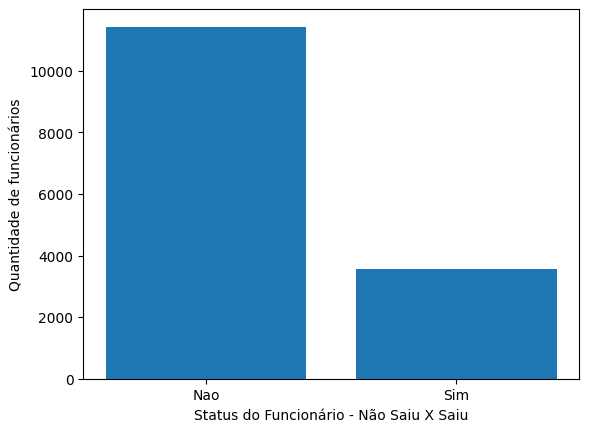

In [15]:
plt.bar(left_count.index.values, totais)
plt.xlabel('Status do Funcionário - Não Saiu X Saiu')
plt.ylabel('Quantidade de funcionários')
plt.show()

Algumas características podem ser melhor analisadas quando o atributo é mostrado em 2 gráficos de forma complementar, como: Totalização do atributo + Agrupamento pela variável alvo (left). Vamos olhar cada caso.

#### 3.2 - Análise Exploratória de Dados

##### 3.2.1 - Gráficos de Distribuição de cada Variável

##### Boxplot

É um gráfico interessante para uma primeira visão da distribuição de valores de uma variável. Além de entendermos 

<Axes: >

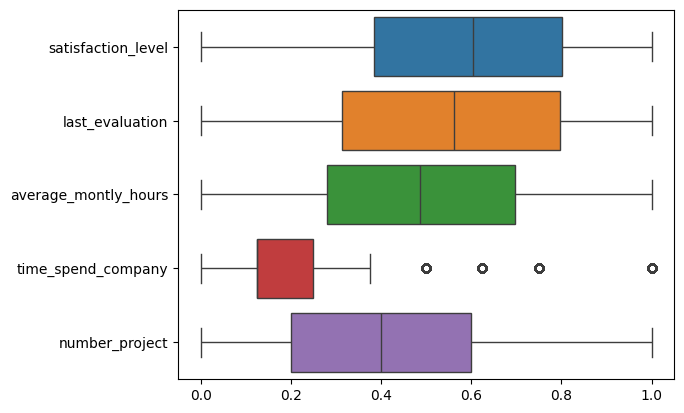

In [16]:
import pandas as pd
_, ds_funcionario_temp_num = preparador.executa_min_scaler(ds_funcionario_temp[atributos_numericos])
ds_funcionario_temp_num = pd.DataFrame(ds_funcionario_temp_num)
ds_funcionario_temp_num.columns = atributos_numericos
sns.boxplot(data=ds_funcionario_temp_num, orient="h")

Em primeira observação, o boxplot mostra assimetria à esquerda para Nível de Satisfação e Última Avaliação - o que representa uma concentração nos maiores valores, ou seja, reflete positivamente no conceito da empresa. Enquanto a Média da Carga Horária e o Número de Projetos, mostra uma assimetria à direita, isto é, os funcionários da empresa se concentram nos valores abaixo da média (de forma geral, menor sobrecarga de trabalho). Mas, o Tempo de Empresa indicam haver outliers.

In [17]:
ds_funcionario_temp['time_spend_company'].describe()

count    14999.000000
mean         3.498233
std          1.460136
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: time_spend_company, dtype: float64

In [18]:
ds_funcionario_temp['time_spend_company'].describe()

count    14999.000000
mean         3.498233
std          1.460136
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: time_spend_company, dtype: float64

**Outliers**

Olhando o Boxpolt, percebemos **valores discrepantes em "time_spend_company"**, mas **não consideramos outliers**, uma vez que existem funcionários com 7, 8 ou 10 anos de casa, embora a média seja 3,5 anos e o desvio padrão 1,46.

In [19]:
print("Contagem de funcionários por tempo de empresa:")
ds_funcionario_temp['time_spend_company'].value_counts()

Contagem de funcionários por tempo de empresa:


time_spend_company
3     6443
2     3244
4     2557
5     1473
6      718
10     214
7      188
8      162
Name: count, dtype: int64

In [20]:
def calcular_outliers_iqr(dados):    
    # Calcula Q1 (25º percentil) e Q3 (75º percentil)
    Q1 = dados.quantile(0.25)
    Q3 = dados.quantile(0.75)
    # Calcula o intervalo interquartil (IQR)
    IQR = Q3 - Q1
    # Define os limites inferior e superior para detecção de outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Retorna uma Série booleana onde True indica um outlier
    outliers = (dados < limite_inferior) | (dados > limite_superior)
    
    return outliers

outliers = calcular_outliers_iqr(ds_funcionario_temp['time_spend_company'])
ds_funcionario_temp[outliers]['time_spend_company'].value_counts()

time_spend_company
6     718
10    214
7     188
8     162
Name: count, dtype: int64

Na empresa não é incomun encontrar funcionários bem adaptados à suas funções e cultura empresarial - ou simplesmente em sua zona de conforto. Mas, não aparenta ser problema de input de dados. São cerca de 8,5% dos funcionários da empresa nesse grupo.

##### Histogramas

Olhando as distribuições no dataset sem filtros

In [21]:
def histograma_atrib_numericos(ds_numericos, rotacionar=False):
    cols = ds_numericos[atributos_numericos].columns
    num_cols = len(cols)
    num_rows = num_cols // 3 + 1

    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 4*num_rows))
    axes = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes[i]
        ds_numericos[atributos_numericos][col].hist(ax=ax, bins=20)
        ax.set_title(col)

    for i in range(i+1, len(axes)):
        axes[i].axis('off')

    fig.tight_layout()
    plt.show()

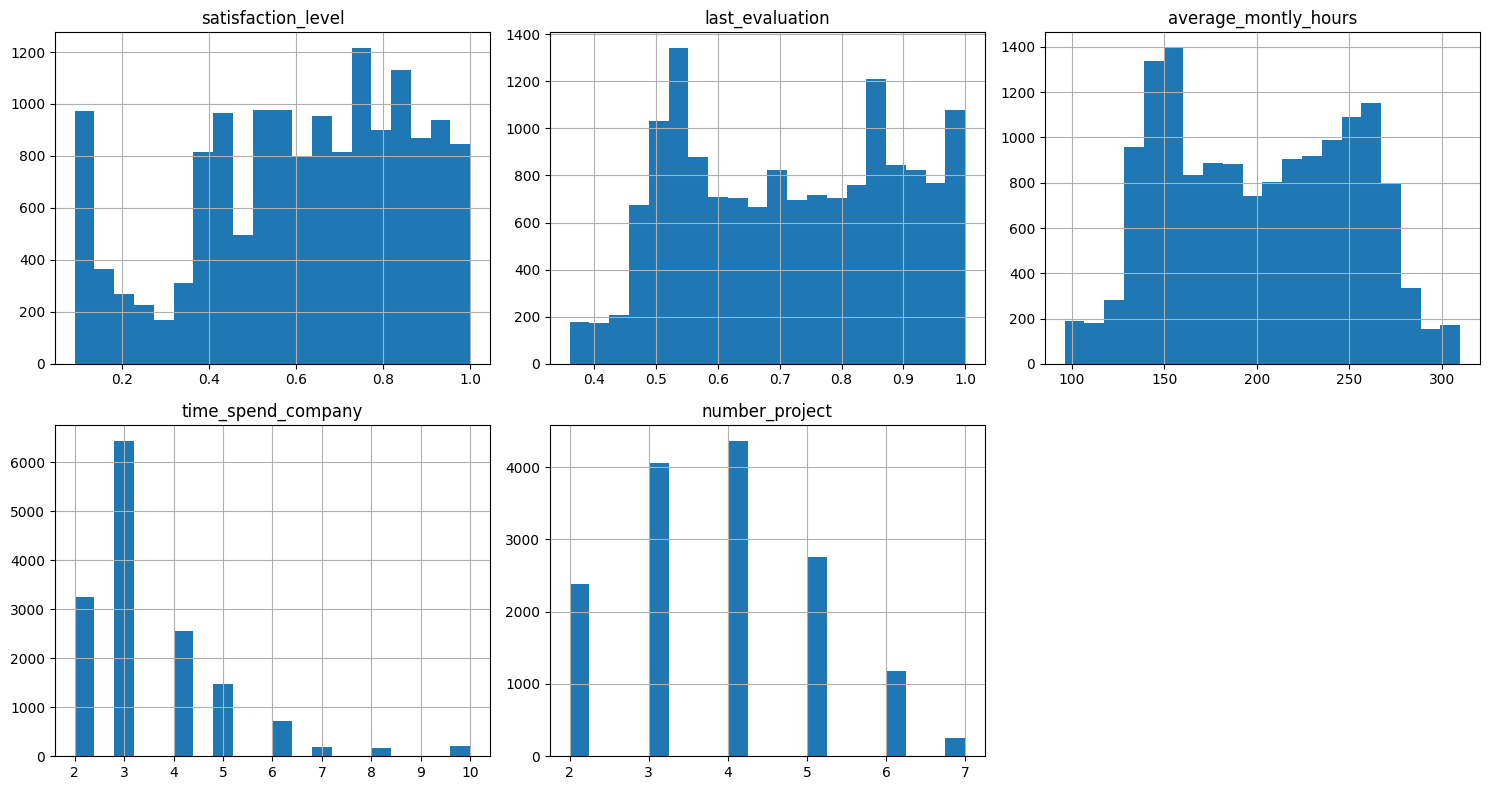

In [22]:
histograma_atrib_numericos(ds_funcionario_temp)

In [23]:
def histograma_atrib_qualitativos(ds_qualitativos, rotacionar=False):
    # Definindo a figura e os subplots (1 linha e 4 colunas)
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    for indice in range(len(atributos_qualitativos)):
        categoria = atributos_qualitativos[indice]
        df = pd.DataFrame(ds_qualitativos[categoria])
        sns.countplot(x=categoria, data=df, ax=axes[indice])
        axes[indice].set_xticklabels(axes[indice].get_xticklabels(), rotation=90)
        axes[indice].set_title(categoria)

    plt.show()

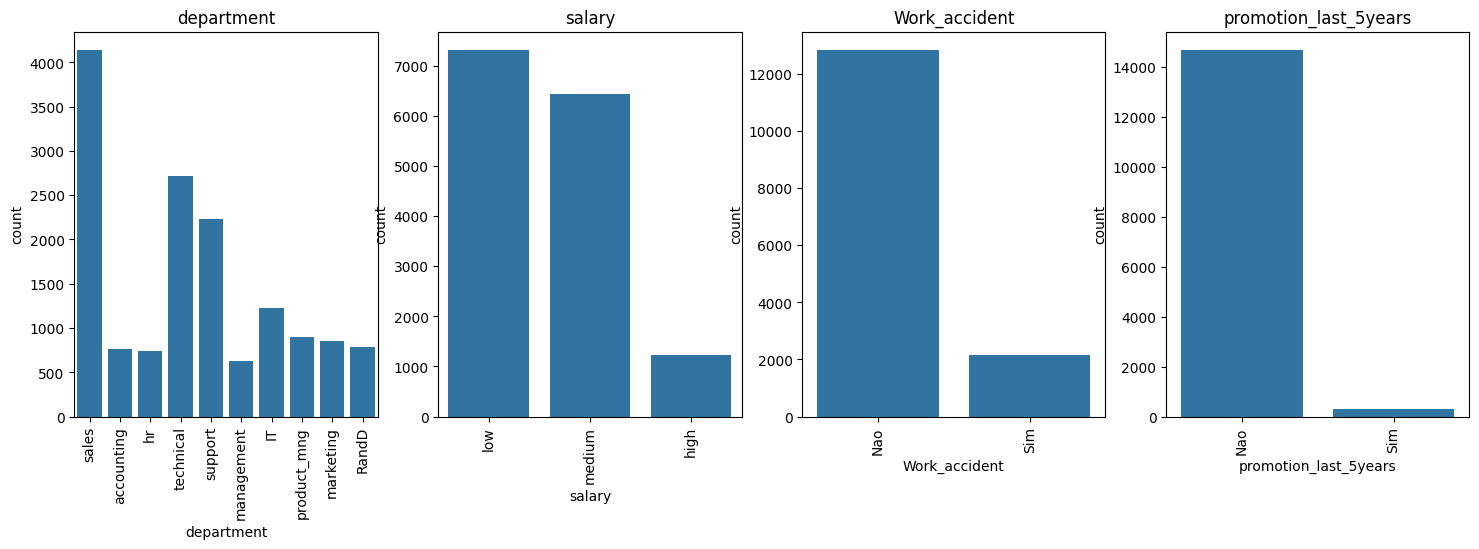

In [24]:
histograma_atrib_qualitativos(ds_funcionario_temp, True)

Filtrando o dataset: distribuição apenas dos funcionários que saíram

Numéricos:


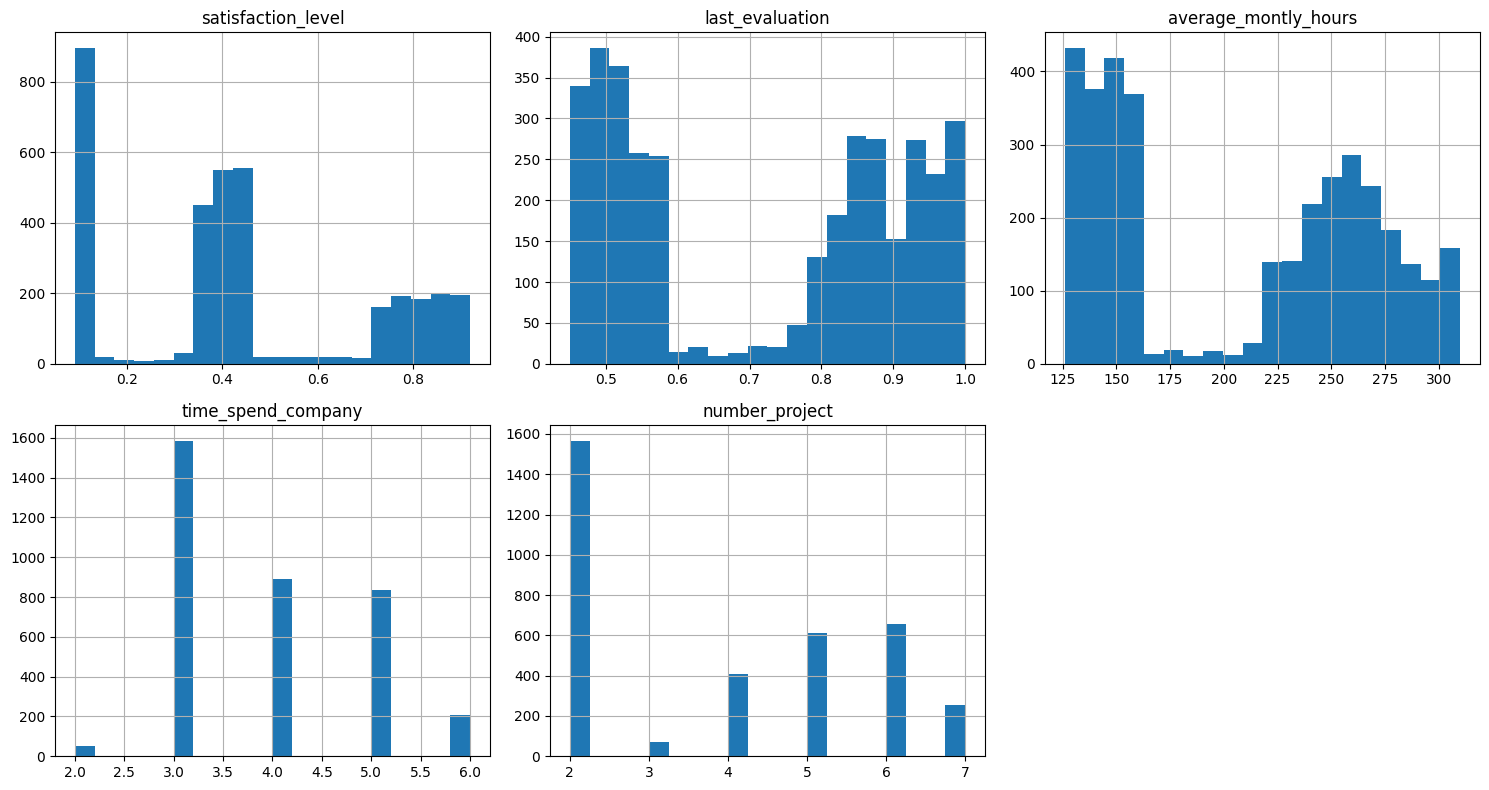

Categóricos:


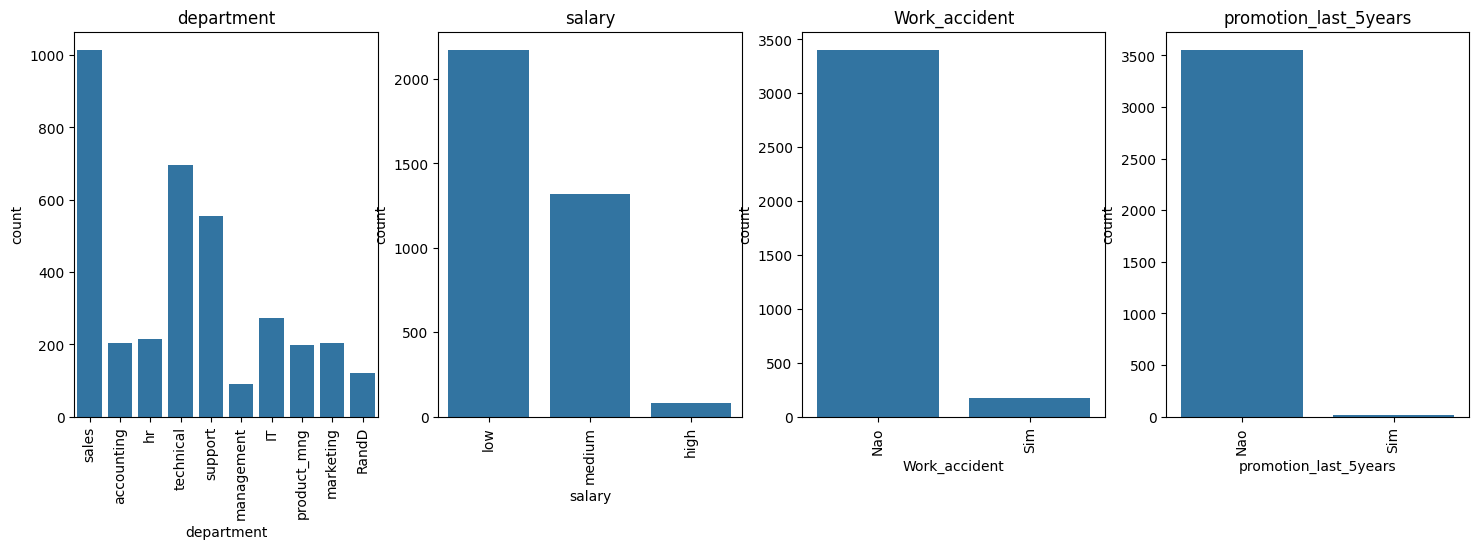

In [25]:
ds_hist_funcionarios_saiu = ds_funcionario_temp[ds_funcionario_temp['left']=='Sim']
print("Numéricos:")
histograma_atrib_numericos(ds_hist_funcionarios_saiu)
print("Categóricos:")
histograma_atrib_qualitativos(ds_hist_funcionarios_saiu, True)

In [26]:
# Gráfico de barras lado a lado: frequência de um atributo e ele segmentado pela saída dos funcionários, de forma a comparar ambos
def plot_complementar(feature, rotacionar=False, ds_funcionario=ds_funcionario_temp):
    graph = plt.subplots(figsize=(20,8))
    
    plt.subplot(1, 2, 1)
    #plt.subplots_adjust(hspace=1.0)
    sns.countplot(x=feature, data=ds_funcionario)
    plt.title('Funcionários')   
    if rotacionar:
        plt.xticks(rotation=90, ha='right')

    plt.subplot(1, 2, 2)
    #plt.subplots_adjust(hspace=1.0)
    sns.countplot(x=feature, data=ds_funcionario, hue='left')
    plt.title('Funcionários')
    if rotacionar:
        plt.xticks(rotation=90)
    plt.show()

In [27]:
def grafico_densidade(atributo, bandwidth=1.0):
    plt.figure(figsize=(6,4))
    ds_saiu = ds_funcionario_temp[ds_funcionario_temp['left']=='Sim'][atributo]
    ds_ficou = ds_funcionario_temp[ds_funcionario_temp['left']=='Nao'][atributo]

    sns.kdeplot(ds_saiu, label = '- Saiu', fill = True, color = 'r', cut=bandwidth)
    sns.kdeplot(ds_ficou, label = '- Ficou', fill = True, color = 'b', cut=bandwidth)

    plt.xlabel(atributo)

#### 3.2.1 - Number_project

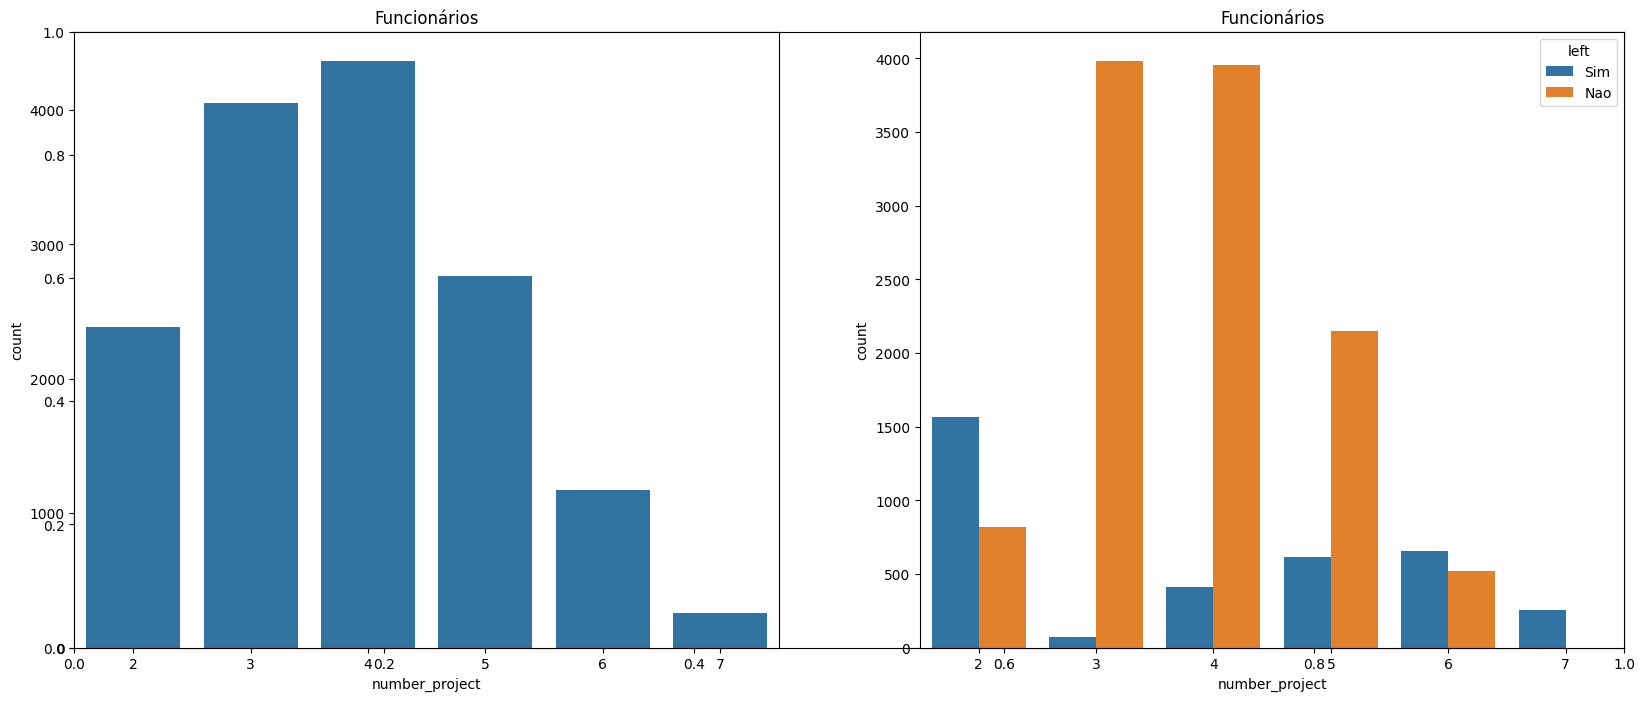

In [28]:
plot_complementar('number_project')

<table>
  <tr><td>Atributos Analisados:</td></tr>
  <tr>
    <td><b>◈ number_project</b></td>
    <td>time_spend_company</td>
    <td>promotion_last_5years</td>
  </tr>
  <tr>
    <td>average_montly_hours</td>
    <td>satisfaction_level</td>
    <td>Work_accident</td>
  </tr>
  <tr>
    <td>last_evaluation</td>    
    <td>salary</td>
    <td>department</td>
  </tr>
</table>

In [29]:
#Quantos funcionários com 7 projetos saíram da empresa?
ds_funcionarios_7_projetos = ds_funcionario_temp[ds_funcionario_temp['number_project'] == 7]
ds_funcionarios_7_projetos['left'].value_counts()

left
Sim    256
Name: count, dtype: int64

Este dataset **não revela** algumas questões importantes, como: a quantidade de projetos está ligada ao nível de especialização/senioridade do funcionário? Qual a complexidade (ou tempo de execução) dos projetos?

A **maioria** dos Funcionários está com **3 a 4 projetos**, totalizando mais de **56%** do pessoal da empresa.

Se considerarmos funcionários **com 3 a 5 projetos, teremos quase 75% do pessoal**. **Não temos** acesso a informações quanto ao impacto financeiro na **receita da empresa / ROI** desses projetos **ou risco de prejuízo**, então é dificil avaliar a criticidade / valor estratégico deles.

Quando os vemos sob a ótica do turnover, o Grupo de funcionários com **2 Projetos**, definitivamente, são **campeões de saída** da organização (sozinho atinge 43,8% delas).

Outro grupo relevante: com **6 projetos** o número de funcionários que **saí é maior do que o que fica** e **todos os 256 funcionários com 7 projetos deixaram** a empresa (7,16% das saídas). O primeiro palpite é sobrecarga de trabalho. É provável que a média da carga horária desse grupo seja maior que a dos demais.

Observar a carga desses projetos mais de perto pode trazer insights sobre diretrizes que guiem políticas para a empresa em geral. Quais atributos eles possuem? Cabe um estudo de **Cluster Analysis**  para melhor entender o cenário? Quais oportunidades de melhorias da Gestão para esses grupos de funcionários podemos apontar e quais sugestões para o **enriquecimento de informações ou de métricas coletadas**?

#### 3.2.2 - time_spent_company (em anos)

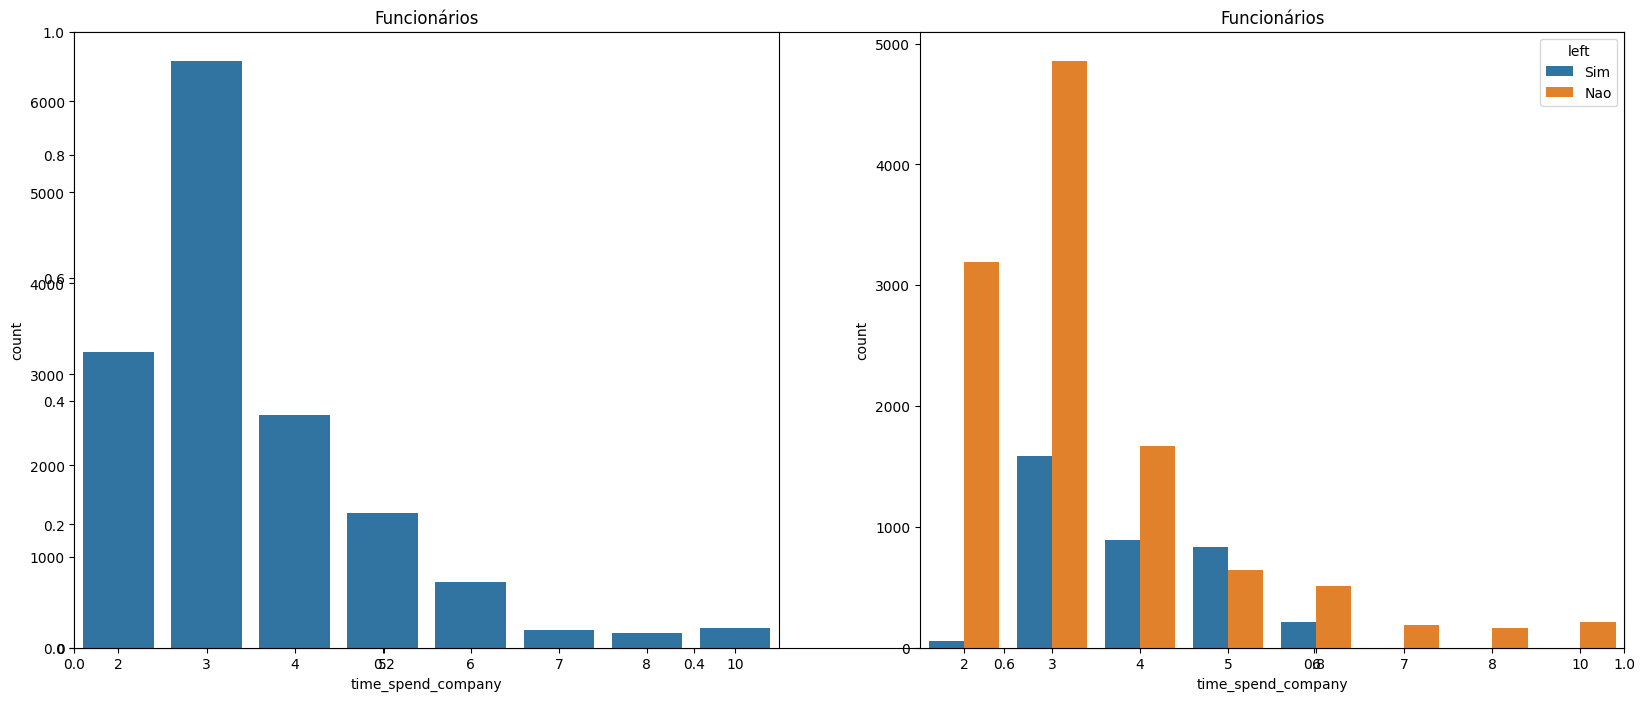

In [30]:
plot_complementar('time_spend_company')

Uma quantidade significativa deixa a empresa com **3 anos de casa** e a maioria dos funcionários está nessa categoria e proporcionalmente, vemos a seguinte taxa de saída nas principais categoria:
- 3 anos: 44,41%
- 4 anos: 24,92%
- 5 anos: 23,33%

Com **6 anos a saída cai** consideravelmente e **não há saídas a partir de 7** anos.

O que podemos avaliar em relação aos "3 anos de casa" considerando também a quantidade de projetos?

% de Saídas 3 anos:  44.41332959955195
---------------------------------------------------
3 Anos de Casa X Quantidade de Projetos:


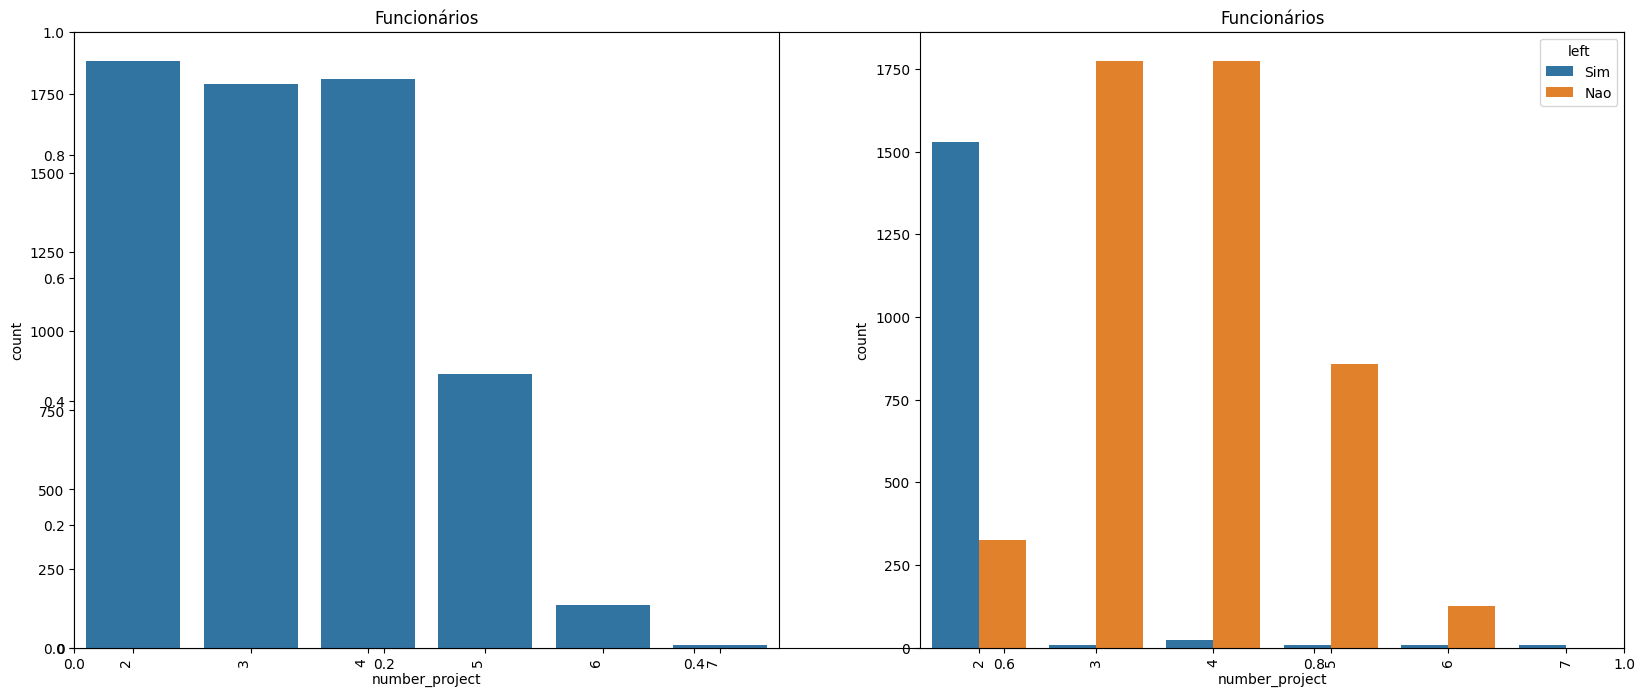

In [31]:
ds_funcionario_3_anos = ds_funcionario_temp[ds_funcionario_temp['time_spend_company'] == 3]

total_saidas = ds_funcionario_temp[ds_funcionario_temp['left'] == 'Sim'].count()[0]
saias_3_anos = ds_funcionario_3_anos[ds_funcionario_3_anos['left'] == 'Sim'].count()[0]   
percentual_saidas_3_anos = (saias_3_anos / total_saidas) * 100

print('% de Saídas 3 anos: ', percentual_saidas_3_anos)
print("---------------------------------------------------")
print("3 Anos de Casa X Quantidade de Projetos:")

plot_complementar('number_project', True, ds_funcionario_3_anos)

In [32]:
#Quantos funcionários com 3 anos de Casa saíram da empresa? 
ds_funcionario_3_anos = ds_funcionario_temp[(ds_funcionario_temp['time_spend_company'] == 3) & (ds_funcionario_temp['left'] == 'Sim')]
total_3_anos = ds_funcionario_3_anos['left'].value_counts()
print("1) Três anos de Casa = ", total_3_anos[0])

#Desses (com 3 anos de Casa) saíram da empresa e tinham 2 projetos ? 
ds_funcionario_2_projetos = ds_funcionario_3_anos[(ds_funcionario_3_anos['number_project'] == 2) & (ds_funcionario_3_anos['left'] == 'Sim')]
total_2_projetos = ds_funcionario_2_projetos['left'].value_counts()
print("2) Dois Projetos e Três anos de Casa = ", total_2_projetos[0])

print(f"Percentual de 3 Anos com 2 Projetos que Saiu: {(total_2_projetos[0]/total_3_anos[0] * 100):.2f} %") 


1) Três anos de Casa =  1586
2) Dois Projetos e Três anos de Casa =  1528
Percentual de 3 Anos com 2 Projetos que Saiu: 96.34 %


A quantidade que saiu da empresa com essa combinação é significativa: 3 anos de empresa e 2 projetos.

Uma análise interessante é olhar qual a **concentração da Carga Horária por Quantidade de Projeto**. Para isso, criamos **categorias com intervalos de 30 h no Power BI** e totalizamos por Quantidade de Projetos.

É perceptível que o Grupo com 2 Projetos possui uma faixa razoável da carga horária bem abaixo da média (201,05 h): de 90 h a 149 h com mais da metade do pessoal totalizando 1.234 funcionários, (51,68%). 

Os Grupos com 2 projetos podem ter baixo valor agregado, menor importância e, portanto, menor remuneração e/ou prespectiva de crescimento.

#### Carga Horária X Quantidade de Projeto (feito no Power BI)
<img src= "../imagens/cargaHoraria_por_projetos.png"  alt="Carga horária por projeto" width="70%" align="left" style="margin:10px 10px 10px 10px">

#### 3.2.3 - promotion_last_5years

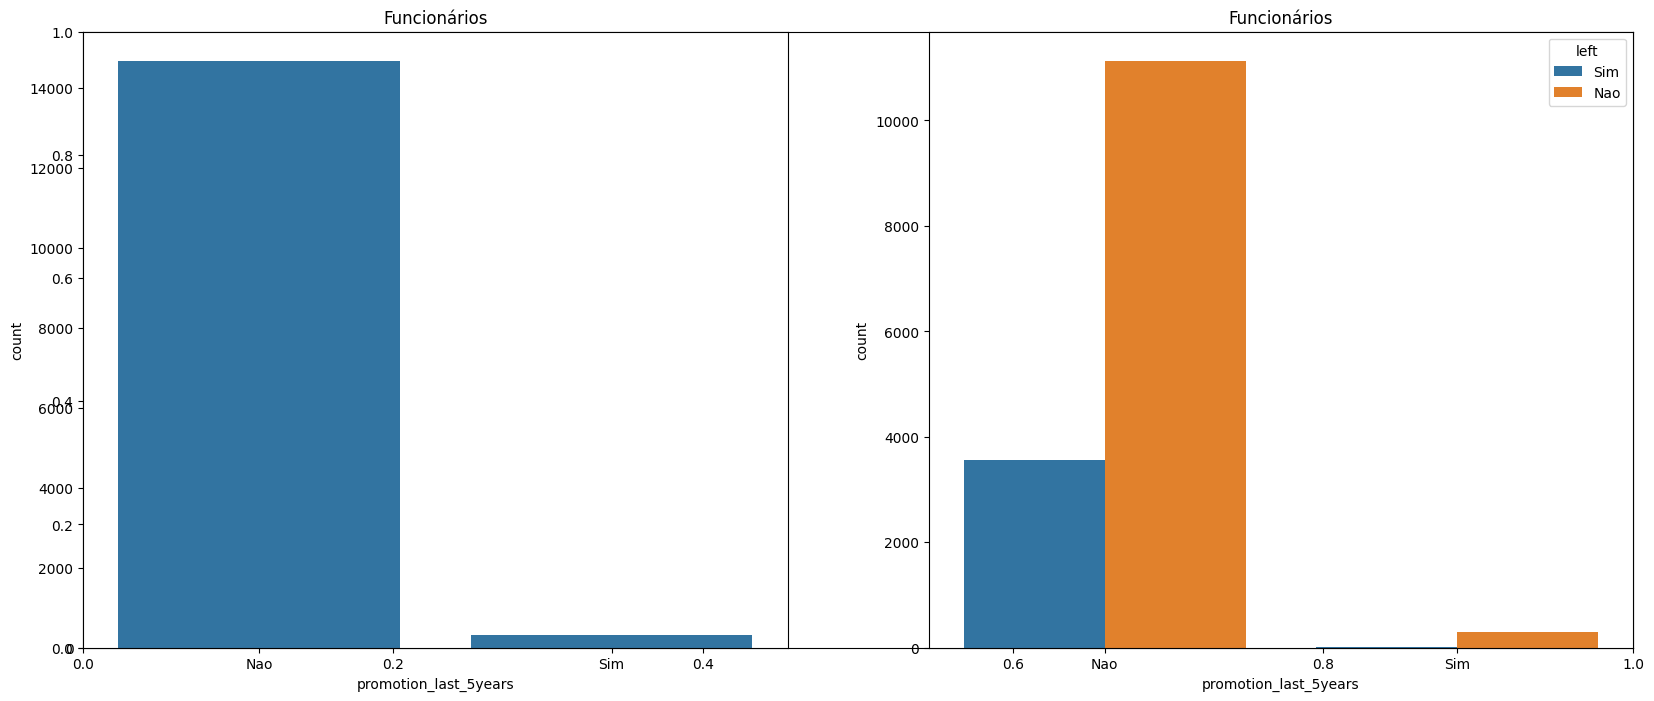

In [33]:
plot_complementar('promotion_last_5years')

<table>
  <tr><td>Atributos Analisados:</td></tr>
  <tr>
    <td>&#10003;number_project</td>
    <td>&#10003;time_spend_company</td>
    <td><b>◈ promotion_last_5years</b></td>
  </tr>
  <tr>
    <td>average_montly_hours</td>
    <td>satisfaction_level</td>
    <td>Work_accident</td>
  </tr>
  <tr>
    <td>last_evaluation</td>    
    <td>salary</td>
    <td>department</td>
  </tr>
</table>

**O percentual** de funcionários que receberam **promoções** nos últimos 5 anos **é mínimo: 2,17%**. Dos que recebram promoção, (319 funcionários) apenas 19 deixaram a empresa - 6,33%. Já entre os que não receberam, 31,92% saíram. Comparando apenas **os que saíram, 94,69% não receberam promoção**.

Esse aspecto pode refletir de maneira **mais indireta sobre a saída**: um índice tão baixo de promoção indica que a empresa não abre espaço para crescimento. Provavelmente não desenvolve Plano de Carreira, Políticas de Cargos e Salários e assim, não incentiva o desenvolvimento a médio-longo prazo. Isto poderia ajudar a explicar a alta taxa de saída principalmente no 3º ano, mas ainda considerável no 4º e 5º?

#### 3.2.4 - average_montly_hours

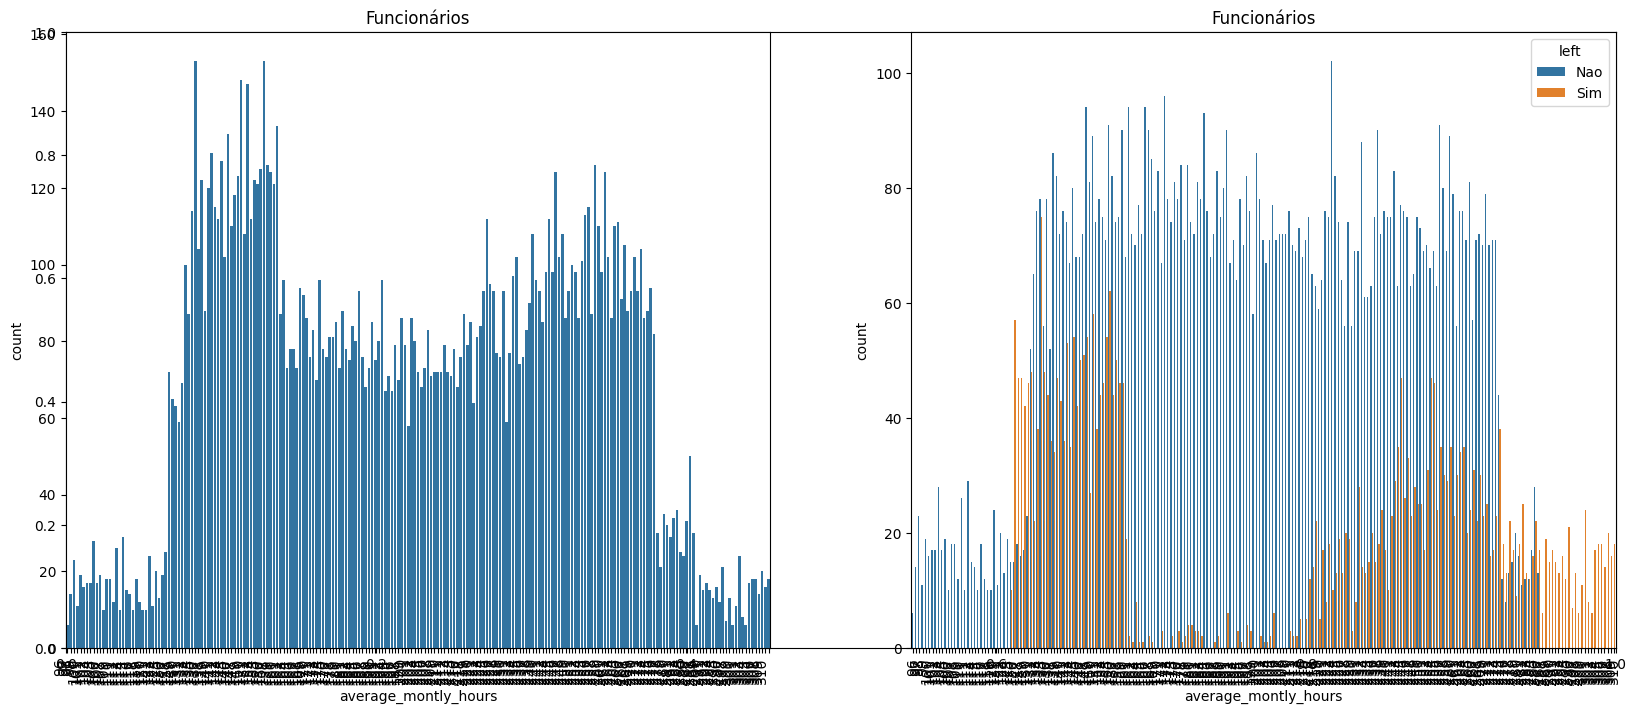

In [34]:
plot_complementar('average_montly_hours', True)

<table>
  <tr><td>Atributos Analisados:</td></tr>
  <tr>
    <td>&#10003;number_project</td>
    <td>&#10003;time_spend_company</td>
    <td>&#10003;promotion_last_5years</td>
  </tr>
  <tr>
    <td><b>◈ average_montly_hours</b></td>
    <td>satisfaction_level</td>
    <td>Work_accident</td>
  </tr>
  <tr>
    <td>last_evaluation</td>    
    <td>salary</td>
    <td>department</td>
  </tr>
</table>

Os valores desse atributo são contínuos, variando entre 96 a 310 - segmentar por faixas de valores pode facilitar a análise. 

No gráfico à esquerda, é possível observar que existem praticamente duas áreas (ou "grupos") que concentram a maioria das médias de horas trabalhadas, uma em cada extremidade.

No gráfico à direita, é possível perceber que a maioria dos funcionários que saiu da empresa também está em grupos na mesma posição, mas talvez não seja tão surpreeendente, já que são onde se encontra a maioria do pessoal.

O próximo gráfico, plotado no **Power BI** oferece uma visão mais detalhada e vemos que existe uma propensão forte ao turnover do pessoal que trabalha no grupo de 131 a 161 h (Já a avaliação de desempenho é menor entre os que saíram (0.52) em relação aos que ficaram (0.71).) e um pouco menos no grupo de 245 a 275 h, mas definitivamente, **o grupo que trabalha mais de 285 h não permance na empresa**. Talvez existam clusters ligados a funções ou projetos específicos.

Abaixo de 125 ou entre o intervalo de 162 a 215


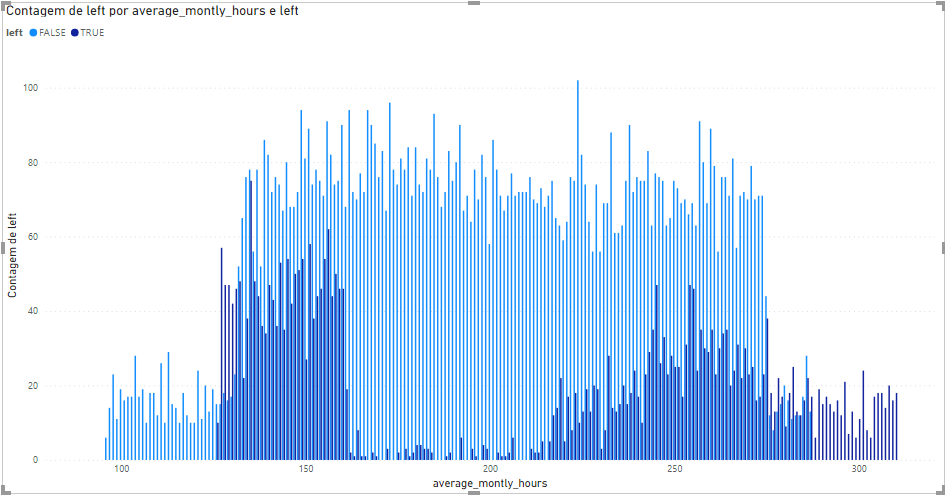

In [35]:
ds_max_carga_permaneceu = ds_funcionario_temp[ds_funcionario_temp['left'] == 'Nao']['average_montly_hours'].max() 
print("Carga hor. Máx. que Permaneceram:",ds_max_carga_permaneceu, "h")

Carga hor. Máx. que Permaneceram: 287 h


Existe um intervalo de horas, **entre 165 e 220 h**, aproximadamente, em que **o índice de turnouver é baixo**. 

**Até 287 h, os funcionários ainda permanecem**, embora a patir de 270 h haja considerável declínio de permanência. **Nenhum** funcionário **com mais de 287 h permanece** na empresa. 

É preciso cruzar esses dados de alta carga horária com o índice de satisfação, cargo, com o salário e eventuais horas-extras a fim de entender melhor o impacto das horas no turnover.

#### 3.2.5 - satisfaction_level

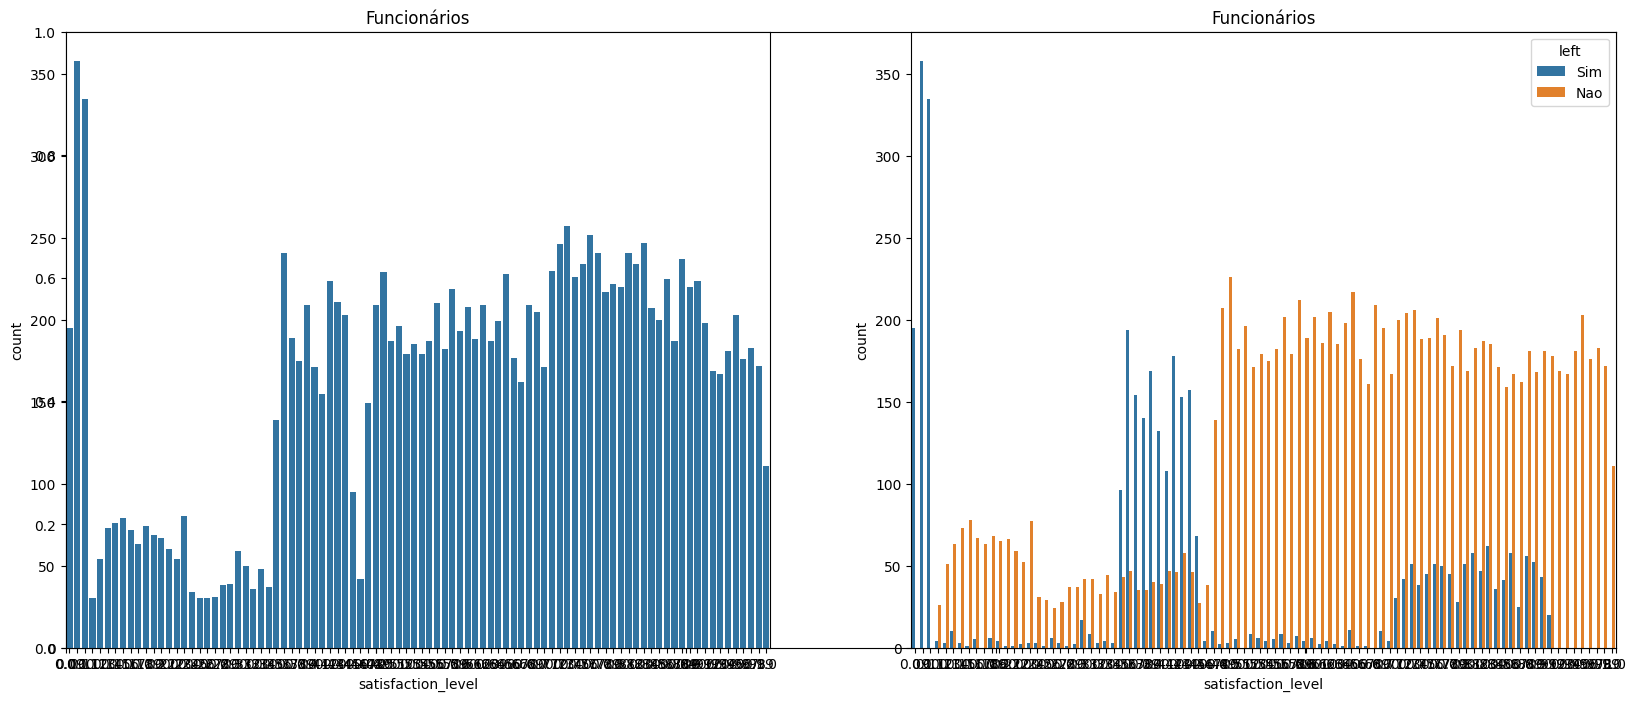

In [36]:
plot_complementar('satisfaction_level')

<table>
  <tr><td>Atributos</td></tr>
  <tr>
    <td>&#10003; number_project</td>
    <td>&#10003; time_spend_company</td>
    <td>&#10003; promotion_last_5years</td>
  </tr>
  <tr>
    <td>&#10003; average_montly_hours</td>
    <td><b>◈ satisfaction_level</b></td>
    <td>Work_accident</td>
  </tr>
  <tr>
    <td>last_evaluation</td>    
    <td>salary</td>
    <td>department</td>
  </tr>
</table>

A empresa tem um nível médio de satisfação levemente positivo: 

- Média: 0,613
- Desvio-padrão: 0,249
- Mediana: 0,640

Vemos 3 "grupos" de maior concentração de saídas: 

Aqueles com avaliações muito baixas (**menores que "11"**), em seguida, o grupo mais numeroso com pontuação entre **"36-46"** e outro, um pouco menor, com satisfação entre **"72-92"**.

- O Grupo com pontuação de "9-11" resultou na **saída de todos os 868** funcionários nessa categoria;
- O Grupo de "36-46" teve **1549 saídas e 463 permanências**; 
- O Grupo "72-92" teve **929 saídas**, contra **3836 retenções**.

A baixa pontuação **não é a causa** da saída: é o reflexo (ou efeito) de outro(s) motivo(s);  

Foi observado no **Power BI** que a o grupo de saídas com alta pontuação ("72-92") trabalha com uma carga horária alta: entre 210 e 330 h, o que pode explicar o turnover, apesar da avaliação. Entretanto, o grupo com pontuação "12-35" teve apenas **94 saídas contra 1189 permanências** - a maioria permaneceu 3 a 5 anos de empresa, mas não localizamos um padrão que revele o motivo desse comportamento - e talvez o atributo que explica não tenha sido capturado neste dataset.



#### 3.2.6 - Work_accident

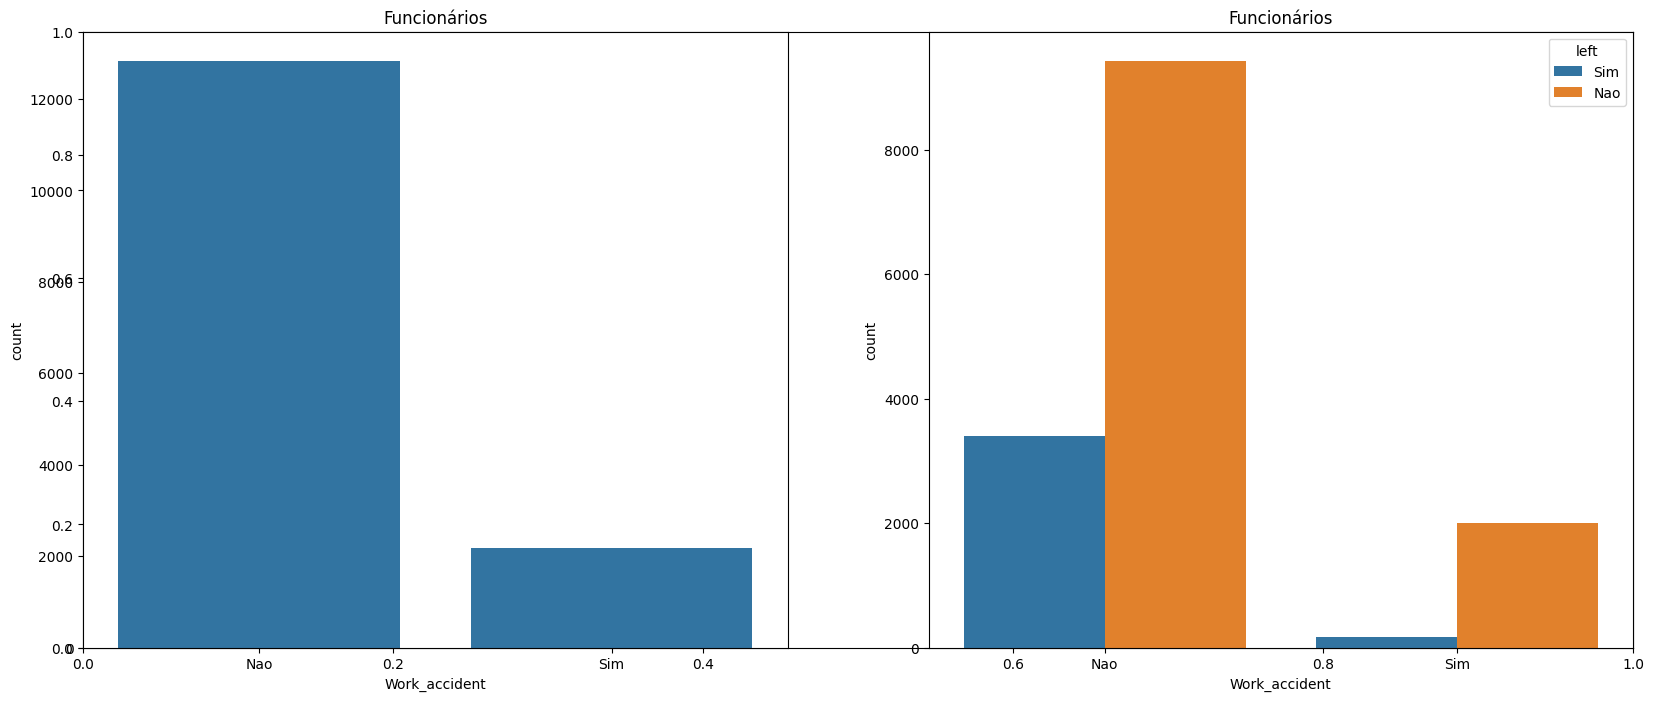

In [37]:
plot_complementar('Work_accident')

In [38]:
#A tabela de Quantidade de Saída de Funcionários(linhas) X Acidente de Trabalho(colunas).  
pd.crosstab(ds_funcionario_temp["Work_accident"], ds_funcionario_temp["left"],margins=True)

left,Nao,Sim,All
Work_accident,,,
Nao,9428,3402,12830
Sim,2000,169,2169
All,11428,3571,14999


<div>
<table>
  <tr><td>Atributos</td></tr>
  <tr>
    <td>&#10003; number_project</td>
    <td>&#10003; time_spend_company</td>
    <td>&#10003;promotion_last_5years</td>
  </tr>
  <tr>
    <td>&#10003; average_montly_hours</td>
    <td>&#10003; satisfaction_level</td>
    <td>◈ <b>Work_accident</b></td>
  </tr>
  <tr>
    <td>last_evaluation</td>    
    <td>salary</td>
    <td>department</td>
  </tr>
</table>
</div>

Vale a pena levantar os números: 14,46% dos funcionários já tiveram ocorrência de Acidente de Trabalho contra 85,54% que não.
Normalmente o índice de acidentes de trabalho é medido anualmente. Neste caso, os dados apresentam um valor contabilizado por funcionários, entretanto, um número próximo a 15% é relativamente alto, podendo indicar que a empresa é de um segmento com trabalho de serviço de campo, industrial ou hospitalar, por exemplo.

Avaliando sob a ótica do turnover, 7,79% dos que sofreram algum tipo de acidente deixaram a empresa. É uma proporção baixa e não aparenta impactar na decisão.

#### 3.2.7 - last_evaluation

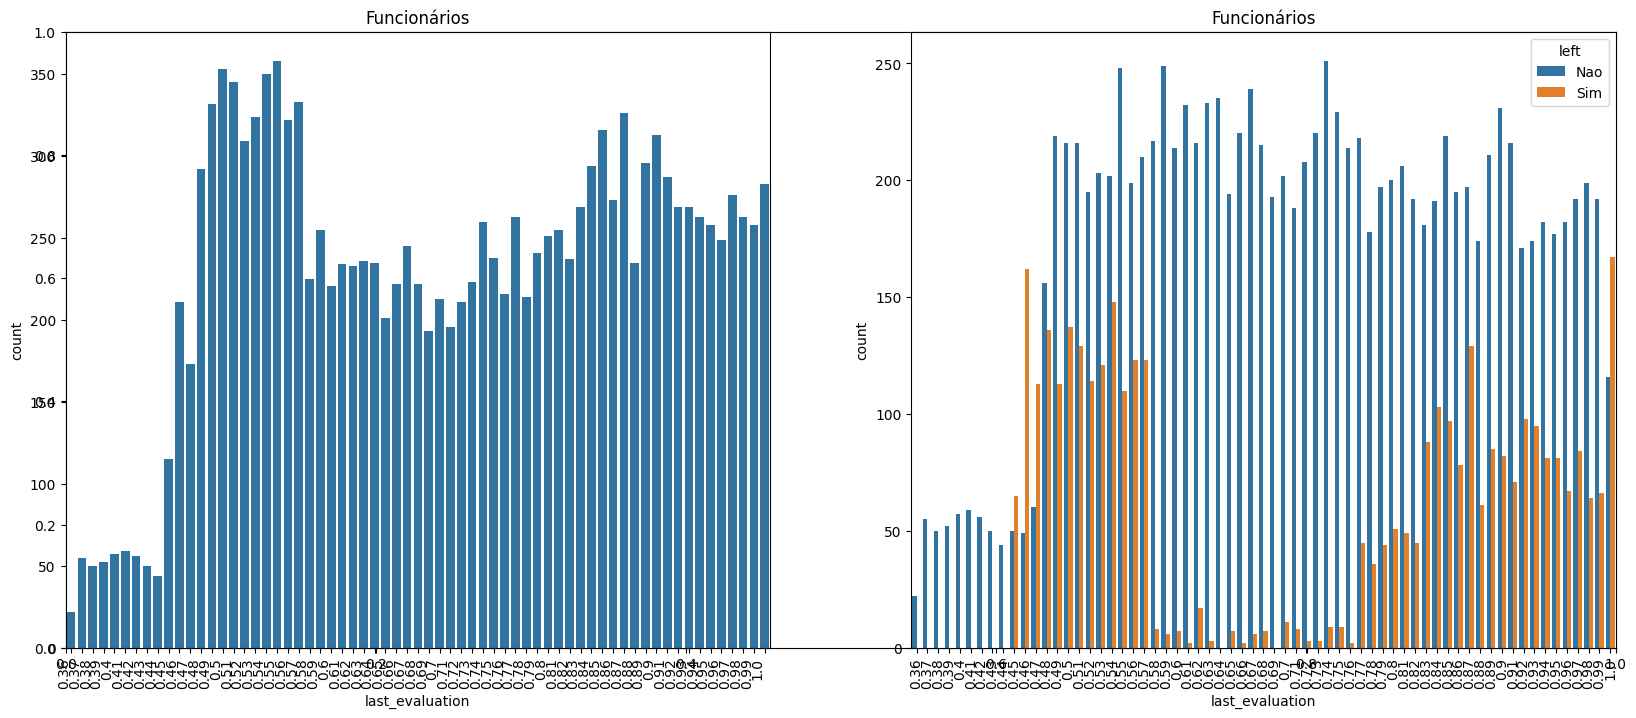

In [39]:
plot_complementar('last_evaluation', True)

<table>
  <tr><td>Atributos</td></tr>
  <tr>
    <td>&#10003; number_project</td>
    <td>&#10003; time_spend_company</td>
    <td>&#10003; promotion_last_5years</td>
  </tr>
  <tr>
    <td>&#10003; average_montly_hours</td>
    <td>&#10003; satisfaction_level</td>
    <td>&#10003; Work_accident</td>
  </tr>
  <tr>
    <td><b>◈ last_evaluation</b></td>    
    <td>salary</td>
    <td>department</td>
  </tr>
</table>


A "última Avaliação de Desempenho" do funcionário é pontuada com valores de 0.0 a 1.0, sendo a amplitude entre 0,36 e 1.0, média de 0,71 e desvio padrão de 0,17 - esses valores colocam o quadro da empresa em um patamar positivo - basta olhar como o **Boxplot é assimétrico** para o lado das **pontuações maiores**. 

É curioso notar que a avaliação não segue uma tendência de distribuição normal - o que revelaria um grupo mais numeroso em torno de um desempenho mediano e outros menos numerosos nas extremidades de desempenho. Os dados podem apresentar vieses dependendo da metodologia utilizada e da subjetividade inerente a certos critérios ou mesmo do avaliador.

Mas, olhando pelo aspecto do turnover, existem **dois grupos relacionados à saída do funcionário**, sendo um na **faixa de desempenho 0,46 a 0,57** e outro **a partir de 0,77**. Paradoxalmente, entre aqueles **com pontuação máxima** (1.0), temos **mais funcionários que saíram (167) do que os que ficaram (116)**. Por isso, não podemos afirmar que quanto menor a avaliação do funcionário, maior a insatisfação em sua relação com a empresa.

Isso mostra um **padrão recorrente**: os funcionários que saem se **concentram em dois grupos** em posições muito semelhantes para os atributos "average_montly_hours", "satisfaction_level" (com exceção apenas de um número expressivo no Grupo inicial) e "last_evaluation". Que interpretação podemos ter? Temos todos os atributos que capturam o motivo desse comportamento?

#### 3.2.8 - Salary

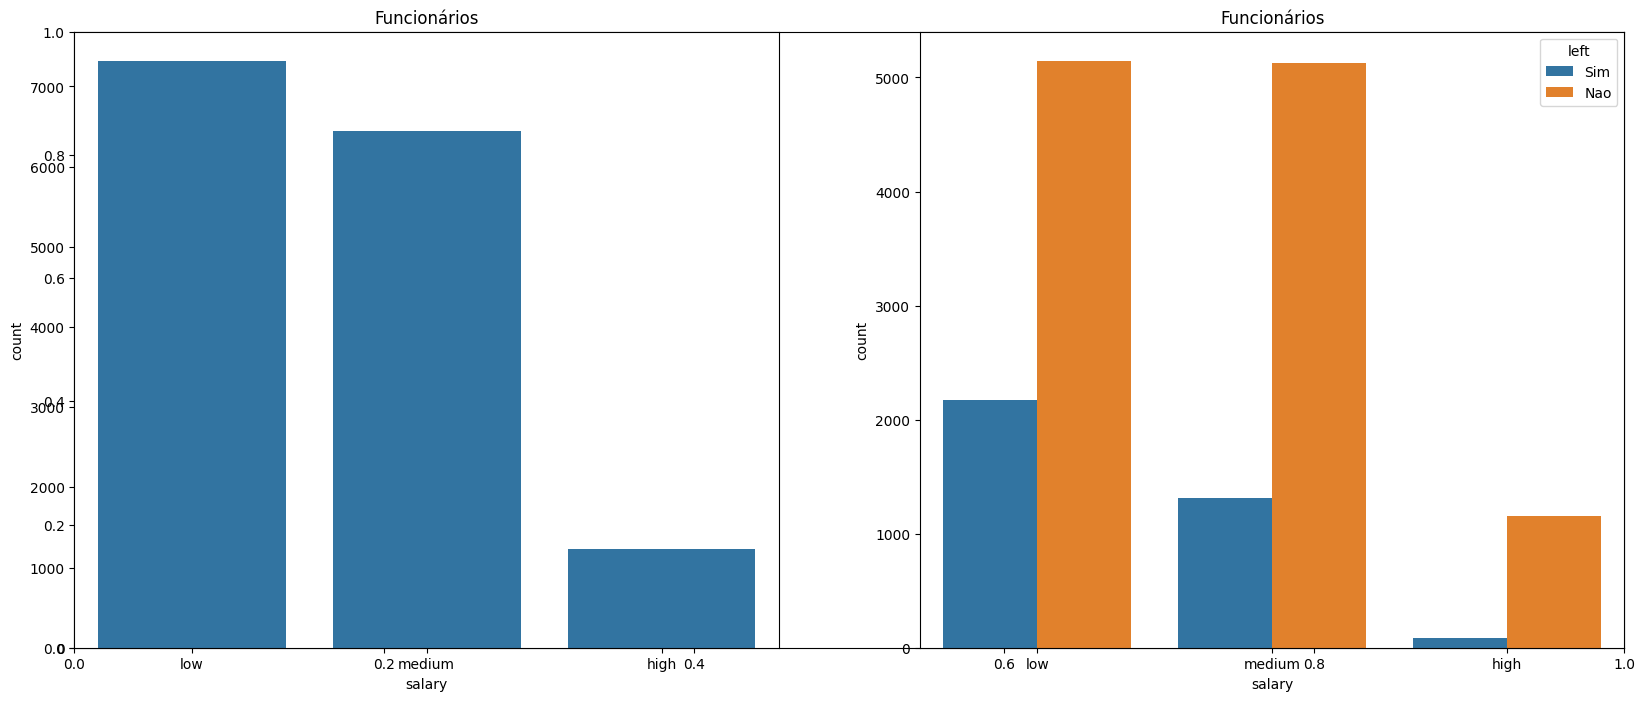

In [40]:
plot_complementar('salary')

<table>
  <tr><td>Atributos</td></tr>
  <tr>
    <td>&#10003; number_project</td>
    <td>&#10003; time_spend_company</td>
    <td>&#10003; promotion_last_5years</td>
  </tr>
  <tr>
    <td>&#10003; average_montly_hours</td>
    <td>&#10003; satisfaction_level</td>
    <td>&#10003; Work_accident</td>
  </tr>
  <tr>
    <td>&#10003; last_evaluation/td>    
    <td><b>◈ salary</b></td>
    <td>department</td>
  </tr>
</table>

Quase metade da empresa **(48,78%) recebe o salário** na categoria **"Baixo"** (low). Sem surpresa, a categoria **"Alto" é** um grupo **minoritário (8,25%)** e **42,98%** está na categoria **"Médio"**. 

Quando olhamos o turnover, é natural que o maior volume de saídas esteja nos baixos salários (29,7% dos funcionários dessa categoria saíram), seguidos por uma quantidade menor nos salários médios (20,4%) e uma quantidade mínima nos altos salários (6,6%) - até por uma questão de proporcionalidade nas categorias. Quanto maior o salário, menor a taxa de saída na respectiva categoria.

**Salário X Departamento:**

<img src= "../imagens/SalarioPorDept.png"  alt="Nível de Satisfação por Permanência" width="60%" align="left" style="margin:10px 10px 10px 10px"> </img>



Os departamentos com **maior quantidade de funcionários** com Altos salários são (top-4): Vendas, Gestão, Técnico e Suporte. Salários Médios: Vendas, Técnico, Suporte e Gestão de Pessoas (RH). Salários baixos: Vendas, Suporte, Técnico e TI.

Os departamentos Técnico, Vendas, Marketing e Suporte se sobressaem em questão de 

#### 3.2.9 - department

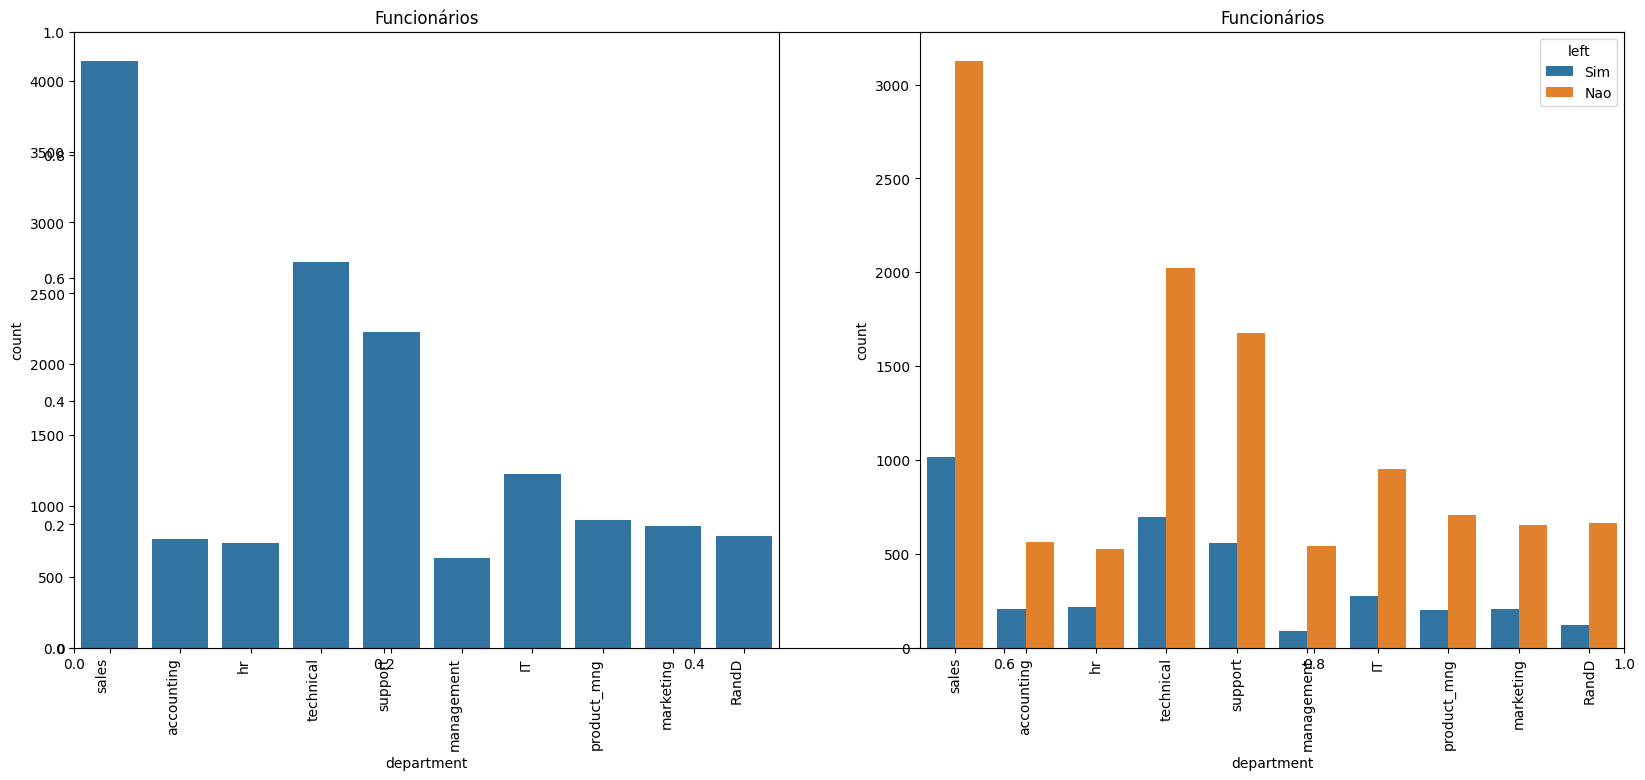

In [41]:
plot_complementar('department', True)

<table>
  <tr><td>Atributos</td></tr>
  <tr>
    <td>&#10003; number_project</td>
    <td>&#10003; time_spend_company</td>
    <td>&#10003; promotion_last_5years</td>
  </tr>
  <tr>
    <td>&#10003; average_montly_hours</td>
    <td>&#10003; satisfaction_level</td>
    <td>&#10003; Work_accident</td>
  </tr>
  <tr>
    <td>&#10003; last_evaluation</td>    
    <td>&#10003; salary</td>
    <td><b>◈ department</b></td>
  </tr>
</table>

**Como os funcionários se distribuem nos departamentos (%)?**

In [42]:
#% de funcionários x departamento
ds_funcionario_temp['department'].value_counts()/len(ds_funcionario_temp)*100

department
sales          27.601840
technical      18.134542
support        14.860991
IT              8.180545
product_mng     6.013734
marketing       5.720381
RandD           5.247016
accounting      5.113674
hr              4.926995
management      4.200280
Name: count, dtype: float64

O Setor da empresa com mais funcionários é Vendas (Sales), com 27,60% do pessoal, seguido por 18.13% no setor Técnico e
14.86% no Suporte, sugerindo que a empresa trabalha com a comercialização de produtos ou prestação de serviço que lida com tecnologia, visto que as equipes de vendas, de técnicos e suporte são os mais representativos.

**% Apenas dos que saíram (por Departamento)**

In [43]:
#% de funcionários que saíram x departamento
ds_funcionario_temp[ds_funcionario_temp['left']=='Sim']['department'].value_counts()/len(ds_funcionario_temp[ds_funcionario_temp['left']=='Sim'])*100

department
sales          28.395407
technical      19.518342
support        15.541865
IT              7.644917
hr              6.020722
accounting      5.712686
marketing       5.684682
product_mng     5.544665
RandD           3.388407
management      2.548306
Name: count, dtype: float64

A **rotatividade** de pessoal **não varia tão significativamente por departamento** e de forma geral segue praticamente a **mesma proporcionalidade da empresa**.

Encerramos as análises das variáveis considerando seu comportamento no conjunto de dados e em relação ao turnover. Mas, ainda podemos tentar achar informações sobre a correlação entre as colunas numéricas. Um "mapa de calor" dessas correlações costuma mostrar quais são mais relevantes.

##### 3.3 Mapa de Calor da Correlação

In [44]:
colunas_correlacao = ['satisfaction_level',	'last_evaluation', 'average_montly_hours','time_spend_company']
correlacoes = ds_funcionario_temp[colunas_correlacao].corr()
correlacoes.head(5)

,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company
satisfaction_level,1.000000,0.105021,-0.020048,-0.100866
last_evaluation,0.105021,1.000000,0.339742,0.131591
average_montly_hours,-0.020048,0.339742,1.000000,0.127755
time_spend_company,-0.100866,0.131591,0.127755,1.000000


A **correlação de Pearson** mostra a força e a direção da **relação linear** entre duas variáveis (-1 para uma relação negativa perfeita e 1, uma relação positiva perfeita).

Os valores de Correlação de Pearson são baixos, indicando **correlações fracas**.

O Mapa de Calor irá mostrar graficamente:

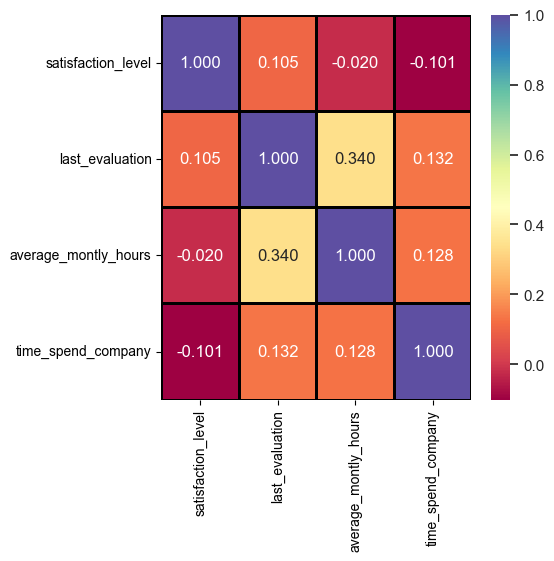

In [45]:
f, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1)
sns.heatmap(correlacoes, annot = True, cmap = "Spectral", linewidths = 1, linecolor = "#000000", fmt='.3f')
plt.show()

A **baixa correlação entre as variáveis** pode indicar que a complexidade não é facilmente explicada por relações lineares simples entre as variáveis. No caso de turnover, vários fatores não numéricos (como cultura organizacional, condições de trabalho, satisfação geral com a vida), podem influenciar a decisão de um funcionário de sair da empresa. Devemos atentar ainda para:

1. Pode haver **relações não lineares que não são capturadas** por este método;

2. Nosso cenário não permite a obtenção de variáveis adicionais e as que estamos analisando podem não ser suficientes para capturar os fatores principais que influenciam o turnover.

3. As **correlações bivariadas não capturam interações entre múltiplas variáveis** - efeitos combinados que não são visíveis quando analisadas isoladamente. 

#### 3.4 Testando Hipóteses

Através das análises realizadas queremos fazer inferirências sobre o comportamento de alguns grupos de funcionários, dadas certas características.

##### 3.4.1 - A Média da Carga Horária dos funcionários

In [46]:
left_Sim = ds_funcionario_temp[ds_funcionario_temp['left'] == 'Sim']['average_montly_hours']
right_Nao = ds_funcionario_temp[ds_funcionario_temp['left'] == 'Nao']['average_montly_hours']
print(f"media 'Sim': {np.mean(left_Sim):.2f}, media 'Nao': {np.mean(right_Nao):.2f}")

media 'Sim': 207.42, media 'Nao': 199.06


**A média da carga horária é significativamente diferente entre os dois grupos (turnover "sim" e "não")**

- H0: A média dos dois grupos **não** apresenta diferenças significativas
- H1: A média dos dois grupos apresenta diferenças significativas

Para determinar o **Teste Estatístico que utilizaremos** para avaliar nossas **hipóteses**, algumas **premissas** devem ser verificadas.

**Teste de Levene**

A **homogeneidade das variâncias** é uma suposição crucial para a validade dos testes estatísticos paramétricos. O **teste de Levene** avalia **se a variabilidade dos dados é semelhante entre os grupos** que estão sendo comparados (a **hipótese nula é que as Variâncias são homogêneas** entre os grupos).

In [47]:
def teste_levene(atributo):
    left_group = ds_funcionario_temp[ds_funcionario_temp['left'] == 'Sim'][atributo]
    right_group = ds_funcionario_temp[ds_funcionario_temp['left'] == 'Nao'][atributo]

    levene_statistic, levene_pvalue = levene(left_group, right_group)

    print(f'Statistic: {levene_statistic:.2f}')
    print(f'p-value: {levene_pvalue:.4f}')

    if levene_pvalue > 0.05:
        print('A hipótese nula não pode ser rejeitada (as variâncias são homogêneas) para', atributo)
    else:
        print('A hipótese nula pode ser rejeitada: as variâncias não são homogêneas para', atributo)

In [48]:
teste_levene('average_montly_hours')

Statistic: 1422.52
p-value: 0.0000
A hipótese nula pode ser rejeitada: as variâncias não são homogêneas para average_montly_hours


 O P-value do teste de Levene é menor que o nível de significância (0,05), então, **rejeitamos a igualdade de variâncias (H0)**, indicando que a variabilidade dos dados é diferente entre os grupos.

 **Teste de Mann-Whitney**

Utilizaremos o **Teste de Mann-Whitney U**: um teste **não-paramétrico** usado para comparar as médias de dois grupos quando a **distribuição** dos dados **não é normal**. Ele se baseia na classificação das observações, em vez dos valores reais.
É robusto à não normalidade e pode ser mais poderoso que o Teste t em algumas situações.

**OBS.:** outros fatores observados
1) a carga horária é um **atributo numérico, discreto**, que **não segue uma distribuição normal**. Mesmo podendo nos valer do _Teorema do Limite Central_ (dispondo de um conjunto de dados com muitas amostras - 14.999 registros) para avaliar a hipótese com um Teste t, optamos por um teste não-paramétrico.

2) conseiderando a não-normalidade da amostra, **outra prosposta** seria o **Teste de Permutação**: se baseia na ideia de embaralhar os dados dos grupos e redistribuí-los aleatoriamente para criar uma distribuição nula. Comparando a estatística de teste observada com a distribuição nula, podemos determinar se a diferença entre os grupos é estatisticamente significante. Neste caso, vamos avaliar usando o Teste Mann-Whitney como já descrito.

In [49]:
def teste_mannwhitneyu(atributo):
    turnover_yes = ds_funcionario_temp[ds_funcionario_temp['left'] == 'Sim'][atributo]
    turnover_no = ds_funcionario_temp[ds_funcionario_temp['left'] == 'Nao'][atributo]
    # Realizando o teste Mann-Whitney U
    stat, p_value = mannwhitneyu(turnover_yes, turnover_no)
    print(f"U-statistic: {stat}, P-value: {p_value}")

In [50]:
teste_mannwhitneyu('average_montly_hours')

U-statistic: 21689600.5, P-value: 1.2769565984354332e-08


O valor de U não é interpretado diretamente em termos de significância (quanto menor o valor de U, maior é a diferença entre as distribuições dos dois grupos), mas com o **P-value < 0,05 rejeitamos a hipótese nula**, indicando que há evidência suficiente para afirmar que **as distribuições dos dois grupos são estatisticamente diferentes** e é improvável que a diferença observada tenha ocorrido por acaso. 

Entretanto, existem comportamentos particulares quanto à Carga horária, dentro de outros segmentos. Por exemplo: a partir de 5 projetos, a quantidade de funcionários que saem é maior do que os que ficam, como já mencionado anteriormente.


##### 3.4.2 - A média de Horas Trabalhadas do Grupo com 5 Projetos ou mais é maior que a dos demais?

- H0: A média de Horas Trabalhadas do "Grupo com 5 Projetos ou mais" é igual aos demais
- H1: A média de Horas Trabalhadas do "Grupo com 5 Projetos ou mais" é maior que os demais

In [51]:
maior_igual_5_proj = ds_funcionario_temp[(ds_funcionario_temp['number_project'] >= 5)]['average_montly_hours']
menor_5_proj = ds_funcionario_temp[(ds_funcionario_temp['number_project'] < 5)]['average_montly_hours']

print(f"media '5 Projetos ou mais': {np.average(maior_igual_5_proj):.2f}, media 'Menos de 5 projetos': {np.average(menor_5_proj):.2f}")

media '5 Projetos ou mais': 223.43, media 'Menos de 5 projetos': 192.37


Novamente, a melhor abordagem seria usar o teste de Mann-Whitney U para duas amostras independentes. 

In [52]:
#Recriando o teste com os 2 grupos desejados
def teste_levene(left_group, right_group):
    levene_statistic, levene_pvalue = levene(left_group, right_group)

    print(f'Statistic: {levene_statistic:.2f}')
    print(f'p-value: {levene_pvalue:.4f}')

    if levene_pvalue > 0.05:
        print('A hipótese nula não pode ser rejeitada')
    else:
        print('A hipótese nula pode ser rejeitada: as variâncias não são homogêneas')
    
teste_levene(maior_igual_5_proj, menor_5_proj)

Statistic: 4.37
p-value: 0.0366
A hipótese nula pode ser rejeitada: as variâncias não são homogêneas


In [53]:
def teste_mann_withney_maior(grupo1, grupo2):
    # Filtrando os dados para os grupos
    stat, p_value = mannwhitneyu(grupo1, grupo2, alternative='greater')

    # Exibindo os resultados
    print(f"U-statistic: {stat}")
    print(f"P-value: {p_value}")

    # Interpretação
    if p_value < 0.05:
        print("Rejeitamos a hipótese nula: Há evidências de que Média 'Grupo 1' é maior.")
    else:
        print("Não rejeitamos a hipótese nula: Não há evidências suficientes evidências de que Média 'Grupo 1' seja maior")

teste_mann_withney_maior(maior_igual_5_proj, menor_5_proj)

U-statistic: 30614897.5
P-value: 4.507688619703967e-246
Rejeitamos a hipótese nula: Há evidências de que Média 'Grupo 1' é maior.


##### 3.4.3 - A média de Horas Trabalhadas do Grupo com até 2 Projetos é menor que a dos demais?
- H0: A média de Horas Trabalhadas do "Grupo com até 2 Projetos" é igual aos demais
- H1: média de Horas Trabalhadas do "Grupo com até 2 Projetos" é menor que os demais

In [54]:
menor_igual_2_proj = ds_funcionario_temp[ (ds_funcionario_temp['number_project'] <=2)]['average_montly_hours']
maior_2_proj = ds_funcionario_temp[(ds_funcionario_temp['number_project'] >2)]['average_montly_hours']
print(f"media '2 Projetos ou menos': {np.average(menor_igual_2_proj):.2f} h, media 'Mais de 2 projetos': {np.average(maior_2_proj):.2f} h")

media '2 Projetos ou menos': 160.34 h, media 'Mais de 2 projetos': 208.76 h


A diferença se mostra bem significativa. Mas, vamos avaliar:

In [55]:
print('Grupo 1: maior_2_proj, Grupo 2: menor_igual_2_proj')
teste_mann_withney_maior(maior_2_proj, menor_igual_2_proj)

Grupo 1: maior_2_proj, Grupo 2: menor_igual_2_proj
U-statistic: 23760865.5
P-value: 0.0
Rejeitamos a hipótese nula: Há evidências de que Média 'Grupo 1' é maior.


##### 3.4.4 - A Proporção de saídas do Departamento de Vendas (Sales) é maior que a dos demais?

- H0: A proporção de saída entre Vendas e os demais Departamentos são iguais
- H1: A proporção de saída entre Vendas é maior que os demais departamentos

Calculando o Percentual de **Saídas** por Departamento

In [56]:
ds_perc_department = ds_funcionario_temp['department'].value_counts()
total_saidas = ds_funcionario_temp[ds_funcionario_temp['left'] == 'Sim'].count()[0]

for department, total_departamento in ds_perc_department.items():
    total_departamento = ds_funcionario_temp[(ds_funcionario_temp['department'] == department) & (ds_funcionario_temp['left']=='Sim')].count()[0]
    print(f'{department}: {(total_departamento/total_saidas * 100):.2f}%')

sales: 28.40%
technical: 19.52%
support: 15.54%
IT: 7.64%
product_mng: 5.54%
marketing: 5.68%
RandD: 3.39%
accounting: 5.71%
hr: 6.02%
management: 2.55%


Quando vemos **28,40% de saídas são do departamento de Vendas** tendemos a achar que ele tem impacto no turnover. Entretanto, **percentual de funcionário em Vendas no quadro da empresa é de 27,60%** - portanto faz sentido. Os demais Departamentos seguem uma proporção semelhante entre total de funcionários x saídas? Vamos verificar.

**Z Score**

Existem diferentes testes de proporções e a escolha depende de alguns fatores, como o tamanho da amostra: utilizaremos o **Teste Z** para Proporções quando as amostras são grandes.

É preciso garantir certas premissas do teste de proporções escolhido. Por exemplo:
- Amostra aleatória: Os dados devem ser coletados aleatoriamente (não conhecemos a metotologia da amostragem, mas supomos que sim)
- Dados binários: A variável de interesse deve ter apenas duas categorias (no caso, o departamento "sales" e os "demais").

In [57]:
def teste_z_proporcoes():
    # Funcionários no departamento "sales"
    total_sales = ds_funcionario_temp[ (ds_funcionario_temp['department'] =='sales')]
    # Saídas (left = Sim) no departamento "sales"
    total_saida_sales = total_sales[ds_funcionario_temp['left']=='Sim']

    # Funcionários de outros departamentos
    total_outros = ds_funcionario_temp[ (ds_funcionario_temp['department'] !='sales')]
    # Saídas nos demais departamento
    total_saida_outros = total_outros[ds_funcionario_temp['left']=='Sim']
    
    # Número de saídas para cada grupo.
    count = [total_saida_sales.shape[0], total_saida_outros.shape[0]]
    # Número total de funcionários em cada grupo.
    nobs = [total_sales.shape[0], total_outros.shape[0]]
    
    # Executando o teste z para proporções
    stat, p_value = proportions_ztest(count, nobs, alternative='larger')

    # Exibindo os resultados
    print(f"Z-statistic: {stat}")
    print(f"P-value: {p_value}")

    # Interpretação
    if p_value < 0.05:
        print("Rejeitamos a hipótese nula: A proporção de saídas no departamento 'sales' é significativamente maior que nos demais departamentos.")
    else:
        print("Não rejeitamos a hipótese nula: Não há evidências suficientes de que a proporção de saídas no departamento 'sales' seja maior.")

teste_z_proporcoes()

Z-statistic: 1.215323674342683
P-value: 0.11212133296166071
Não rejeitamos a hipótese nula: Não há evidências suficientes de que a proporção de saídas no departamento 'sales' seja maior.


Neste caso, trabalhar em **Vendas não tem um impacto relevante no turnover**.

A (In)Satisfação dos grupos que pontuaram entre 0,3 e 0,5 é refletida principalmente nos funcionários com 2 projetos: 1528 saídas.

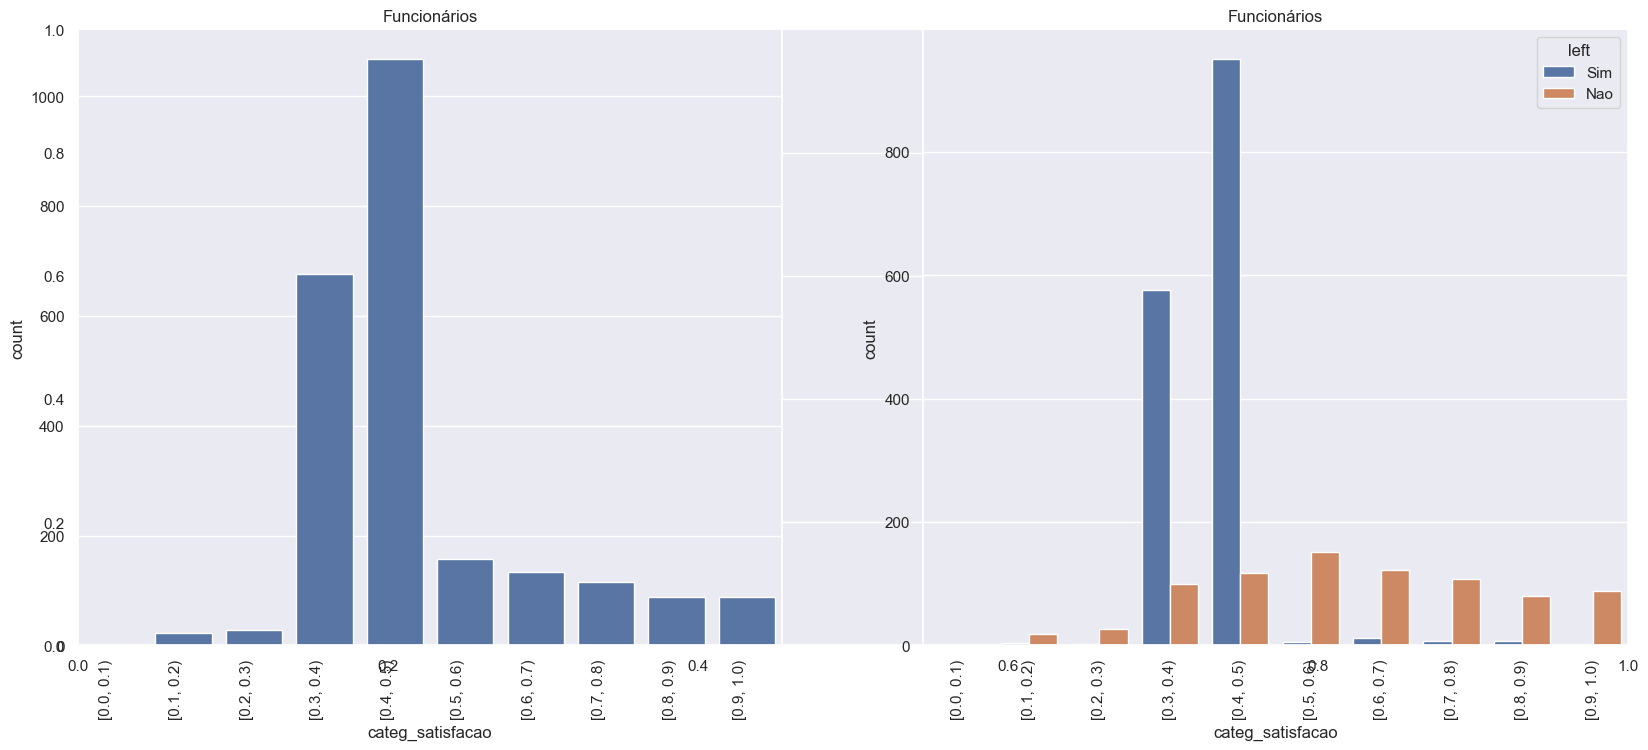

In [58]:
import matplotlib.pyplot as plt
ds_2_projetos = ds_funcionario_temp[ds_funcionario_temp['number_project'] == 2]
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ds_categ_satisfacao = pd.cut(ds_2_projetos['satisfaction_level'], bins=bins, right=False)
ds_2_projetos['categ_satisfacao'] = ds_categ_satisfacao
plot_complementar('categ_satisfacao', True, ds_2_projetos)

Os números mais **críticos do turnover** são:
- Trabalhar com 2 projetos
- Ter 3 anos de empresa
- Remuneração "Baixa" (48,78% dos funcionários), principalmente, e "Média" *(42,98%) em seguida, mas com menor impacto
- Não receber promoção nos últimos 5 anos (os que tem 3 anos e ainda não foram promovidos já contabilizam um valor significativo)
- Trabalhar com cargas horárias < 150 h ou > 220 h (> 287 h não permanecem na empresa)

### 3.5 - Analise de Clusters
Qual o impacto da Satisfação e da Análise de Desempenho no turnover da empresa? E as cargas horárias trabalhadas mensalmente ou o tempo de experiência? Vamos procurar Perfis de funcionários no grupo de turnover.

Estas **análises** serão feitas apenas sobre os **funcionários que saíram**. Em que partes do gráfico os valores convergem mais?

In [59]:
def analisa_clusters(dataset, feature1, feature2, num_cluesters):
    left_emp = dataset[[feature1, feature2]][dataset.left=='Sim']
    kmeans = KMeans(n_clusters=num_cluesters, random_state=0).fit(left_emp)

    left_emp['label'] = kmeans.labels_

    plt.scatter(left_emp[feature1], left_emp[feature2], c=left_emp['label'], cmap='Accent')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title('Grupos de funcionários que saíram')
    plt.show()

last_evaluation X satisfaction_level


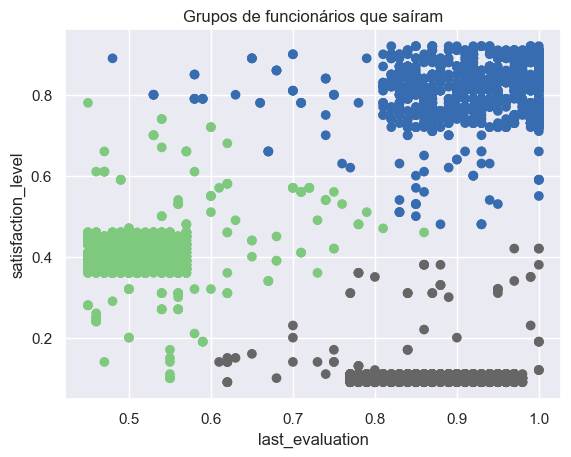

In [60]:
print('last_evaluation X satisfaction_level')
analisa_clusters(ds_funcionario_temp, 'last_evaluation', 'satisfaction_level', 3)

Depois de alguns testes, observamos que 3 grupos representam melhor os perfis desta análise:
* Os funcionários com **alta Satisfação e alto Desempenho** (canto superior direito) desfruram da melhor situação, apesar de ser **grupo mais numeroso a deixar a empresa**. Entretanto, essa idéia parece contra-intuitiva e deve haver outra variável que explique melhor esse comportamento;
* Satisfação baixa a moderada e Desempenho médio / alto (inferior direito), é o grupo que se esforça, mas não está satisfeito - menor volume de saída;
* Satisfação baixa a moderada e Desempenho médio a baixo (esquerda central), são do grupo dos que não trabalham bem e não eetão muito satisfeitos. É o grupo de volume intermediário.

average_montly_hours X last_evaluation


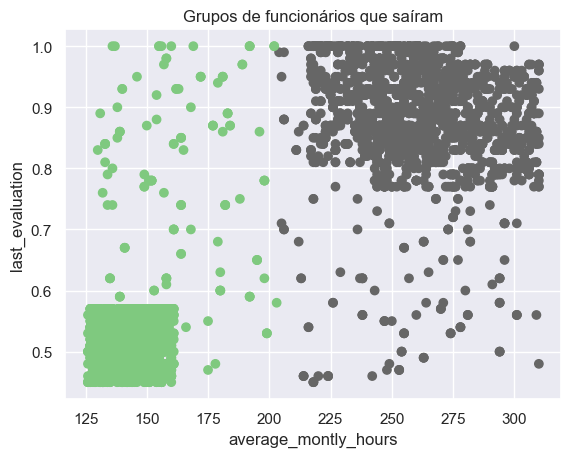

In [61]:
print('average_montly_hours X last_evaluation')
analisa_clusters(ds_funcionario_temp,'average_montly_hours', 'last_evaluation', 2)

Dois Grupos representam bem esse perfil:
- Os que trabalham muito e tiveram ótima avaliação de desempenho, mas são os que mais saíram da empresa. O problema são os critérios de avaliação ou a alta carga horária mensal?;
- Os que trabalham bem menos e que não são bem avaliados. Pode haver impacto no salário devido à baixa carga horária ou mal-estar devido a falta de engajamento na empresa (avaliação com baixa performance).

average_montly_hours X satisfaction_level


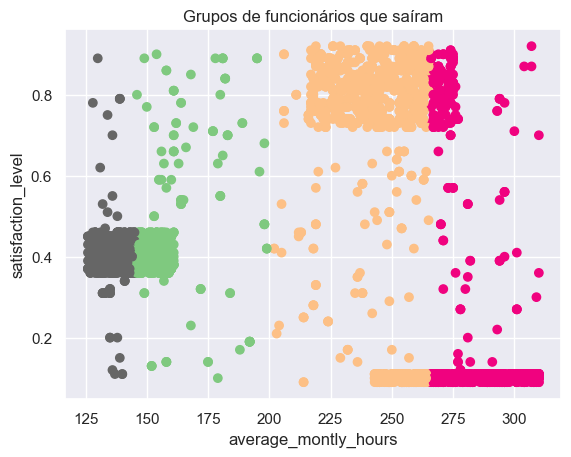

In [62]:
print('average_montly_hours X satisfaction_level')
analisa_clusters(ds_funcionario_temp, 'average_montly_hours', 'satisfaction_level', 4)

Os clusters que aparecem sempre se dividem por faixas de carga horária. Encontrar grupos "coesos" visualmente requer análise criteriosa. 

Quando analisamos anteriormete os gráficos de barras do grupo de turnover para *average_montly_hours*, havia 3 grupos principais: "131 a 161 h (...) 245 a 275 h, (...) grupo que trabalha mais de 285 h". Quando analisamos o satisfaction_level, havia um grupo mais numeroso de baixa satisfação e outro menor com um nível de satisfação alto.

Quando cruzamos essas duas informações percebemos que o perfil mais representativo é o de alta carga horária. Mais surpreendente é que mesmo com alta satisfação, existe um grande movimento de saída e "carga horária" é algo a ser investigado. A concentração de saída, quando a carga horária é pequena (novamente, talvez refletindo em um baixo salário?), está mais relacionada à média satisfação. Por isso, estudar melhor a quantidade de horas trabalhadas pode ser uma oportunidade.

Altas cargas de trabalho podem estar relacionadas à processos ineficientes, baixa qualidade de produção/prestação de serviço (exigindo retrabalhos) ou metas altas de desempenho (vendas, por exemplo), o que reflete na empresa como um todo. 

### 3.6 Recomendações com base na Análise:
* **Balanceamento de Projetos**: as categorias com maior satisfação (pontuação maior ou igual a 0.7) estão responsáveis por **3 a 4 projetos**, sendo esses grupos os de **maior retenção**. A empresa deve **avaliar e monitorar** a atribuição de **mais de 4 projetos**; 
* **Equilíbrio da Carga de Trabalho**: volumes mensais muito baixos ou muito altos estão diretamente relacionados a índices maiores de saída. **Para altas cargas**, ainda que seja necessário extrapolar uma certa quantidade de horas, medidas como **Banco de Horas a descontar** ou alternância entre meses com mais horas e meses moderados, seria indicado. Para **cargas muito baixas**, a empresa pode **engajar o funcionário** em programas de **nivelamento da produtividade** para manter entre 170 e 220 h; 
* **Acompanhamento da Satisfação**: principalmente **a partir dos 3 anos** de empresa (maior grupo com índice de saídas). A satisfação deve ser acompanhada sempre, mas aqueles que completam 3 anos estão mais sujeitos ao turnover - por isso, a próxima recomendação também está relacionada a esta;
* **Política de Promoção**: crescimento profissional é um conhecido fator de retenção. O baixíssimo índice de promoção reflete nas decisões de muitos dos funcionários e deixar claro **um programa de evolução profissional** mostra que a empresa possibilita crescimento;
* **Política Salarial**: a quantidade de funcionários dentro da categoria "Salário baixo" é quase metade do quadro (48,78%). Este fator tem efeito direto na retenção, mas **não é** o tipo de medida **simples de criar ou implementar**. Mas, pode **alavancar um nível de serviço melhor**, criar oportunidades de melhoria e recolocação da empresa no mercado. **Planos de desenvolvimento profissional** também são recomendados;
* **Avaliação de Desempenho X Carga Horária X Satisfação**: dois indicadores importantes são o **Grupo em que todos apresentam valores baixos** e o **Grupo em que todos apresentam valores altos**. No primeiro, as medidas mencionadas anteriormente devem suavizar o efeito do turnover. **No segundo**, entretanto, pode ser que **a empresa esteja perdendo funcionários para o mercado**. Reverter isso a curto prazo nem sempre está ao alcance da Gestão. Isso requer medidas mais amplas a longo prazo e pode envolver outros aspectos já mencionados também: política salarial, promoções, suavização da carga horária e desenvolvimento profissional.
* **Indicadores de Desempenho Empresarial**: por fim, essas medidas precisam ser acompanhadas para medir seu impacto na performance da empresa ao longo do tempo (indicadores Globais e Setoriais).


### 4 - Criando o Modelo Preditivo
---

Estamos trabalhando em um problema típico de Machine Learning para Predição (Classificação) Supervisionada.

Para efeitos de análise utilizamos o conjunto de dados ainda sem a adequação necessária ao processamento dos algorítmos de Machine Learning - que muito frequentemente aceitam apenas valores numéricos e rejeitam atributos com valores ausentes. Consequentemente, a transformação de categorias em números torna-se necessária, assim como a verificação se todos os campos estão preenchidos. Para codificação usaremos algumas estratégias disponíveis nas bibliotecas Python, como Label Encoding e One-Hot Encoding.

Outra característica necessária é que esses valores não estejam muito distantes em escala entre um atributo e outro. Mais uma vez, utilizaremos uma ténica de normalização disponível: MinMaxScaler.

Em seguida, particionaremos a base em Treino e Teste de forma que possamos fazer o Modelo aprender com os dados de Treino e avaliamos o desempenho dele com os dados de Teste.

A coluna que identifica de forma única um funcionário (ID) é normalmente eliminada assim como seu nome (anonimizada), tanto por não ser relevante para uso em análise e predição, quanto por questões de legislação (LGPD). Neste dataset isso já foi feito.

Vamos nos certificar que não existem valores ausentes no conjunto de dados, caso contrário poderá ser necessário usar técnicas de preenchimento ou remoção dos valores - seja da amostra (registro), seja do atributo (coluna) como um todo.

In [63]:
#Algum valor nulo?
ds_funcionarios.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

#### 4.1 - Tratamento do Conjunto de Dados - Feature Engineering

##### 4.1.1 - Enconding

Utilizaremos o OneHot, ou seja, a técnica em que cada atributo categórico irá gerar uma nova coluna no conjunto de dados para cada valor distinto que possui (na realidade, n-1 para não ter redundância) e a nova coluna receberá um valor binário [0 / 1]: 1, caso o valor da coluna corresponda ao "valor original" ou 0, em caso contrário. Essa técnica evita que um atributo categórico ganhe uma "atribuição" numérica/aritmética a ser utilizada pelo algorítmo.

Existem outras abordagens quando o número de colunas do conjunto de dados cresce muito, causando a alta dimensionalidade que, por sua vez, iria requerer outros tratamentos. Aqui não chegaremos a uma quantidade impactante e por isso manteremos a simplicidade.

In [64]:
print("Antes de preparação:", ds_funcionarios.shape)
encoder_onehot, ds_hr_encoded = preparador.tratamento_encoder(ds_funcionarios)
print("Após a preparação:", ds_hr_encoded.shape)

Antes de preparação: (14999, 10)
Após a preparação: (14999, 19)


Vale a pena comentar que o Feature Engineering, na maioria das vezes, utiliza os valores da base de treinamento para definir a transformação dos atributos. Quando for para a produção, precisará considerar o mesmo cenário e os mesmos parâmetros de transformação dos dados. Uma forma de realizar isso é salvar o Enconder em um __Pickle__ para reutilizar depois.

**Salvando o Onehot Encoder com o Fit da base treinada** para uso na Produção

In [65]:
with open("salvos/onehot.pkl", "wb") as pickle_file:
    pickle.dump(encoder_onehot, pickle_file)

#### 4.1.2 - Particionamento dos dados em Treino e Teste
Inicialmente podemos separar a coluna que é o interesse da classificação (variável dependente "left") das colunas preditoras (as demais variáveis independentes). Depois, utilizamos a téncica de Split para Treino e Teste

Observando os dados do conjunto final vemos que, por exemplo, comparando os valores de atributos como satisfaction_level e average_montly_hours, vemos uma diferença razoável de escala: enquanto Nível de Satisfação pode ter valores como 0,09 a Carga Hoária Mensal pode chegar a 310. Essas diferenças de escala *podem* (depende dos algorítmos e técnicas utlizadas) interferir na performance assertiva do modelo.

Como estamos numa fase de avaliação dos algorítmos, vale a pena utilizar a normalização de valores e assim ficarmos livres para experimentação. A técnica que utilizaremos envolve o redimensionamos os dados numéricos do intervalo original para que todos os valores se encaixem num intervalo de 0 e 1.


In [66]:
ds_X, ds_y = preparador.compondo_datasets_x_y(ds_hr_encoded, ds_funcionarios, atributos_numericos)

In [67]:
ds_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   satisfaction_level    14999 non-null  float64
 1   last_evaluation       14999 non-null  float64
 2   average_montly_hours  14999 non-null  int64  
 3   time_spend_company    14999 non-null  int64  
 4   number_project        14999 non-null  int64  
 5   0                     14999 non-null  float64
 6   1                     14999 non-null  float64
 7   2                     14999 non-null  float64
 8   3                     14999 non-null  float64
 9   4                     14999 non-null  float64
 10  5                     14999 non-null  float64
 11  6                     14999 non-null  float64
 12  7                     14999 non-null  float64
 13  8                     14999 non-null  float64
 14  9                     14999 non-null  float64
 15  10                 

O Encoder gerou colunas com rótulos de 0 a 18. Para que não haja problemas com os algoritmos, vamos renomeá-las de forma automatizada, colocando o prefixo "encode" + o número gerado:

In [68]:
#Renomeando as colunas após o OneHot Encoder
novas_colunas = {coluna_atual: f'encode{coluna_atual}' for coluna_atual in ds_X.columns[5:]}
colunas_inciais = list(ds_X.columns[:5])
colunas_dataset = colunas_inciais + list(map(lambda coluna: coluna, novas_colunas.values()))

ds_X.columns = colunas_dataset
ds_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   satisfaction_level    14999 non-null  float64
 1   last_evaluation       14999 non-null  float64
 2   average_montly_hours  14999 non-null  int64  
 3   time_spend_company    14999 non-null  int64  
 4   number_project        14999 non-null  int64  
 5   encode0               14999 non-null  float64
 6   encode1               14999 non-null  float64
 7   encode2               14999 non-null  float64
 8   encode3               14999 non-null  float64
 9   encode4               14999 non-null  float64
 10  encode5               14999 non-null  float64
 11  encode6               14999 non-null  float64
 12  encode7               14999 non-null  float64
 13  encode8               14999 non-null  float64
 14  encode9               14999 non-null  float64
 15  encode10           

In [ ]:
ds_X.head()

,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,number_project,encode0,encode1,encode2,encode3,encode4,...,encode9,encode10,encode11,encode12,encode13,encode14,encode15,encode16,encode17,encode18
0,0.38,0.53,157,3,2,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.80,0.86,262,6,5,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.11,0.88,272,4,7,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.72,0.87,223,5,5,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.37,0.52,159,3,2,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##### Split do Dataset
Dividindo o Dataset para o treinamento e validação inicial

In [70]:
proporcao_teste = 0.3
X_treino, X_teste, y_treino, y_teste = train_test_split(ds_X, ds_y, test_size=proporcao_teste, random_state = 58)

In [71]:
# Executamos a normalização depois do Split a fim de não trazer variações do futuro (dados de teste)  
# para o modelo. Com isso, criamos uma versão mais robusta e se a distribuição muda em Teste,  
# reavaliamos o dataset, verificamos ordenação ou cronologia, o balanceamento dos dados, etc.
minmax_encoder, X_treino = preparador.executa_min_scaler(X_treino)
minmax_encoder, X_teste = preparador.executa_min_scaler(X_teste)

Salvando o Min Max Encoder

In [72]:
with open("salvos/minmax.pkl", "wb") as pickle_file:
    pickle.dump(minmax_encoder, pickle_file)

### 4.2 - Algoritmos Preditivos
#### 4.2.1 - Baseline - Começando com Regressão Logística
Estamos estudando uma solução que nos leve ao melhor resultado, utilizando determinados recursos - sejam técnicos, sejam computacionais, sejam de projeto.

Conjuntos de Dados possuem características que juntamente com o problema a resolver influenciam na escolha do algorítimo e para processá-las em busca da solução utilizaremos esses recursos.

Vamos traçar uma "linha inicial" utilizando um modelo sem grande complexidade e avaliar o resultado. Vamos começar com Regressão Logística, avaliar sua performance e pensar em como evoluímos para outros modelos de acordo com o resultado.
Regressão Logística é uma ténica interessante para casos como o nosso em que queremos prever a probabilidade de ocorrer um de dois valores possíveis.

Obs.: O algoritmo usa por default a técnica de regularização L2 para balancear a capacidade de generalização e evitar overfiting.

In [73]:
#Classe de Criação dos Algoritmos dos modelos preditivos
class ModelosPreditivos():
  def logistic_regression(self, dataset_x_treino, dataset_y_treino, dataset_X_test):
    modeloRegressaoLogi = LogisticRegression()
    modeloRegressaoLogi.fit(dataset_x_treino, dataset_y_treino)
    y_pred_regressao_logi = modeloRegressaoLogi.predict(dataset_X_test)
    return y_pred_regressao_logi, modeloRegressaoLogi

  def KNN(self, dataset_x_treino, dataset_y_treino, dataset_X_test):
    model_knn = KNeighborsClassifier(n_neighbors=2)
    model_knn.fit(dataset_x_treino, dataset_y_treino)
    predic_knn = model_knn.predict(dataset_X_test)
    return predic_knn

  def SVM (self, dataset_x_treino, dataset_y_treino, dataset_X_test, kernel_type, shape, regularizacao_C=1.0, gamma_coef='scale', degree_poly=3):
    modelo_svm = SVC(kernel=kernel_type, C=regularizacao_C, decision_function_shape=shape, gamma=gamma_coef, degree=degree_poly).fit(dataset_x_treino, dataset_y_treino)
    predicao_svm = modelo_svm.predict(dataset_X_test)
    return predicao_svm

  def grid_search_svm(self, grid_parametros, dataset_x_treino, dataset_y_treino, dataset_X_test):
    grade = GridSearchCV(SVC(), grid_parametros, refit = True, verbose = 0)
    grade.fit(dataset_x_treino, dataset_y_treino)
    print(grade.best_params_)
    print(grade.best_estimator_)
    predicao_grade_svm = grade.predict(dataset_X_test)
    return predicao_grade_svm

  def XGBoost(self, dataset_x_treino, dataset_y_treino, dataset_X_test):
    modelo_xgboost = XGBClassifier(dataset_x_treino, dataset_y_treino, dataset_X_test)
    modelo_xgboost.fit(dataset_x_treino, dataset_y_treino)
    pred_xgboost = modelo_xgboost.predict(dataset_X_test)
    return pred_xgboost

In [74]:
#Preparando o handler dos modelos
modelosPreditivos = ModelosPreditivos()

In [75]:
y_pred_reg_logi, modelo_logi = modelosPreditivos.logistic_regression(X_treino, y_treino, X_teste)

##### 4.2.1.1 - Métricas de Desempenho

Podemos usar mais de uma métrica na hora de verificar a performance de um modelo de __classificação__, mas basicamente partimos de uma Matriz de Confusão, que nos traz alguns conceitos essenciais **sobre medição das previsões** do modelo:

- Positivas corretas (TP ou Positivos verdadeiros);
- Negativas corretas (TN ou Negativos verdadeiros);
- Positivas incorretas (FP ou Falsos positivos);
- Negativas incorretas (FN ou Falsos negativos);

**OBS.:** "positivo" ou "negativo" não são conceitos fixos e sim termos relativos ao significado das previsões no cenário do problema a se analisar ou resolver. Isso significa que podemos adotar conceitos para positivo ou negativo em nosso trabalho, à conveniência do nosso objetivo. Isso logo será exemplificado.

Então, para avaliar seu desempenho temos esses resultados combinados, gerando as seguintes métricas de avaliação:

- **Acurácia**: Revela qual o percentual de acertos do modelo em relação ao total, ou seja, são todos os acertos positivos e todos os acertos negativos em relação ao total de amostras. 

- **Precision**: avalia a exatidão do modelo em relação às previsões positivas, calculando a taxa entre os Positivos Corretos (TP) e todos os Positivos previstos (TP + FP). É uma métrica **importante** quando os **Falsos Positivos (FP) são mais impactantes** que os Falsos Negativos (FN). Por exemplo, se estivermos concedendo crédito para financiamento, o FP irá liberar crédito para clientes propensos à inadimplência gerando prejuízo, enquanto que o FN irá deixar de liberar o financiamento (geração de receita) para esse cliente;

- **Recall**: avalia a capacidade de prever as classes positivas reais, mas enquanto a Precision é impactada pelos erros de Falsos Positivos, a Recall é impactada pelos erros dos Falsos Negativos, pois calcula a taxa dos Positivos Verdadeiros previstos em função de todos os Positivos existentes (Positivo Verdadeiro + Falsos Negativos). Assim, essa métrica é importante em situações em que os Falsos Negativos são mais prejudiciais que os Falsos Positivos, como diagnosticar erroneamente que um paciente não tem a doença quando, na realidade, é portador. 

- **F1-Score**: As duas métricas anteriores possuem propóstitos ligeiramente diferentes, mas e se quisermos olhar diretamente apenas uma métrica? Quando buscamos um equilíbrio entre Precision e Recall usamos a média harmônica entre as duas (aproxima mais dos menores valores do que uma média aritmética). Assim, um F1-Score baixo indicas que ou a precisão ou o recall está baixo.

In [76]:
def imprime_acuracia(predicao, yTeste):
  print('Acurácia: {} %'.format( accuracy_score(predicao, yTeste)*100 ))
  print('Relatorio sw Classificacao: \n', classification_report(yTeste, predicao>0.5))

##### Matriz de Confusão de Predições do Modelo

In [77]:
conf_matx = confusion_matrix(y_teste, y_pred_reg_logi)

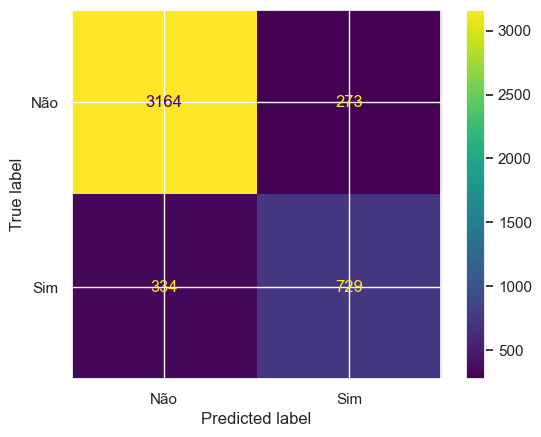

In [78]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matx, display_labels=["Não", "Sim"])
disp.plot()
plt.show()

In [79]:
imprime_acuracia(y_pred_reg_logi, y_teste)

Acurácia: 86.51111111111112 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      3437
           1       0.73      0.69      0.71      1063

    accuracy                           0.87      4500
   macro avg       0.82      0.80      0.81      4500
weighted avg       0.86      0.87      0.86      4500



Nosso **baseline** começou com uma **acurácia de 86,51%** no modelo preditivo. Não é tão ruim - considerando que não há desbalanceamento em nossos dados - mas, nosso objetivo é aumentar a taxa de acerto através de experimentação com outros algorítmos e otimização dos mesmos trabalhando o conjunto de dados ou os hiperparâmetros do algorítimo.

A previsão da classe "0" na variável _Left_ equivale a "Permanecerá" (ou "Não sairá") da empresa, enquanto "1" equivale a "Deixará a empresa", então, quando o **modelo prevê "não" (0)**, em tese, ficamos tranquilos. E quando prevê "sim" (1) a Gestão de Pessoas e a Gerência terão que avaliar o impacto da perda desse funcionário e a capacidade de reverter essa tendência (ou minimizá-la). Mas, **quão confiáveis são essas previsões?** Vejamos, conforme o relatório de performance as métricas precision, recall e f1-score referentes a cada uma dessas classes:

##### Previsão 0 (não sairá)
- Precisão: 90% das vezes que o modelo previu a permanência do funcionário, ele estava correto.
- Recall: 92% dos funcionários que realmente não saíram foram classificados corretamente.
- F1-Score: 0,91 - indicando um bom equilíbrio entre precisão e recall.

##### Previsão 1 (irá sair)
- Precisão: 73% das vezes que previu a saída de um funcionário, estava correto.
- Recall: 69% dos funcionários que realmente saíram foram identificados corretamente.
- F1-Score: 0,71 - uma queda de desempenho nessa classe.

Em números:

O total de "Sim" do Dataset de Teste era de 1063 amostras e o modelo conseguiu prever corretamente 729, mas errou os outros 334, prevendo que permaneceriam - essa é a quantidade em que a empersa seria "pega de surpresa".

Também houve o inconveniente de 273 previsões como "sim" que não se concretizaram de fato.

Portanto, o modelo é **menos assertivo sobre a saída** (quando deixa de identificar que o funcionário irá sair). Pior ainda, é que o Recall é de 69%. Aqui é que está o problema: este erro, tipicamente, custa mais para a empresa. Queremos melhorar essas métricas da "Classe" 1 (o Sim).

#### 4.2.2 - KNN

In [80]:
predicao_knn = modelosPreditivos.KNN(X_treino, y_treino, X_teste)
imprime_acuracia(predicao_knn, y_teste)

Acurácia: 96.24444444444444 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      3437
           1       0.92      0.92      0.92      1063

    accuracy                           0.96      4500
   macro avg       0.95      0.95      0.95      4500
weighted avg       0.96      0.96      0.96      4500



Sensível melhora no resultado preditivo: a **Acurácia** foi para **96,24%** e o **Recall** da classe 1 para **0,92**. A **Precision** da classe 0 está em **0,97**.

#### 4.2.3 - SVM

Realizamos testes nos Kernels fornecidos na bliblioteca do sklearn.svm com valores típicos dos hiperparâmetros e o Kernel Polinomial obteve a melhor perfirmance:

In [81]:
predicao_svm1 = modelosPreditivos.SVM(X_treino, y_treino, X_teste, 'linear', 'ovo')
predicao_svm2 = modelosPreditivos.SVM(X_treino, y_treino, X_teste, 'rbf', 'ovo',gamma_coef=1.0)
predicao_svm3 = modelosPreditivos.SVM(X_treino, y_treino, X_teste, 'poly', 'ovo', degree_poly=5)
predicao_svm4 = modelosPreditivos.SVM(X_treino, y_treino, X_teste, 'sigmoid', 'ovo')

In [82]:
print('Linear----------------------------------')
imprime_acuracia(predicao_svm1, y_teste)
print('RBF----------------------------------')
imprime_acuracia(predicao_svm2, y_teste)
print('Polinomial----------------------------------')
imprime_acuracia(predicao_svm3, y_teste)
print('Sigmoid----------------------------------')
imprime_acuracia(predicao_svm4, y_teste)

Linear----------------------------------
Acurácia: 84.44444444444444 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      3437
           1       0.67      0.68      0.67      1063

    accuracy                           0.84      4500
   macro avg       0.78      0.79      0.79      4500
weighted avg       0.85      0.84      0.85      4500

RBF----------------------------------
Acurácia: 94.35555555555555 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      3437
           1       0.89      0.87      0.88      1063

    accuracy                           0.94      4500
   macro avg       0.93      0.92      0.92      4500
weighted avg       0.94      0.94      0.94      4500

Polinomial----------------------------------
Acurácia: 94.88888888888889 %
Relatorio sw Classificacao: 
               precision    recall  f1-scor

Alguns ajustes nos parâmetros foram feitos e dada a melhoria de performance observada optamos por evoluir a abordagem anterior para um GridSearch.

A variação que observamos em cada modelo se deve aos ajustes de hiperparâmetros que fizemos. É possível gerar uma quantidade limitada de valores para todos os parâmetros desejados e rodar as combinações deles.

#### 4.2.4 - GridSearch com SVM
Portanto, a ideia nessa técnica é criar uma grade de hiperparâmetros, selecionando-os com alguns critérios, e tentar todas as suas combinações. Os parâmetros que queremos combinar são fornecedios em um dicionário com os valores desejados.

Uma advertência: computacionalmente essa estratégia é exigente e quanto mais valores de um determinado hiperparâmetro criamos, aliado à quantidade que combinamos deles, maior o tempo de processamento!

In [83]:
parametros_grid = {'C': [0.1, 1, 10, 100],
                   'gamma': [1, 0.1, 0.01, 0.001],
                   'degree': [2,4,6],
                   'kernel': ['linear','rbf', 'poly', 'sigmoid']}

In [84]:
predicao_grade_svm = modelosPreditivos.grid_search_svm(parametros_grid, X_treino, y_treino, X_teste)

{'C': 100, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=100, degree=2, gamma=1)


In [85]:
imprime_acuracia(predicao_grade_svm, y_teste)
print(classification_report(y_teste, predicao_grade_svm))

Acurácia: 95.88888888888889 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      3437
           1       0.90      0.93      0.91      1063

    accuracy                           0.96      4500
   macro avg       0.94      0.95      0.94      4500
weighted avg       0.96      0.96      0.96      4500

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3437
           1       0.90      0.93      0.91      1063

    accuracy                           0.96      4500
   macro avg       0.94      0.95      0.94      4500
weighted avg       0.96      0.96      0.96      4500



Estes foram os hiperparâmetros definidos como os melhores entre aqueles sugeridos:
{'C': 100, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}

O melhor modelo, portanto, terá os seguintes hiperparâmetros, com acurária de **96,57%**:

In [86]:
modelo_svm = SVC(kernel='rbf', C=1000, decision_function_shape='ovo', gamma=1).fit(X_treino, y_treino)
##predicao_svm3 = modelosPreditivos.SVM(X_treino, y_treino, X_teste, 'rfb', 'ovo', gamma_)
predicao_svm = modelo_svm.predict(X_teste)
imprime_acuracia(predicao_svm, y_teste)

Acurácia: 96.57777777777777 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3437
           1       0.91      0.95      0.93      1063

    accuracy                           0.97      4500
   macro avg       0.95      0.96      0.95      4500
weighted avg       0.97      0.97      0.97      4500



Com todos os **hiperparâmetros otimizados** todas as métricas subiram ligeiramente em relação ao KNN.

#### 4.2.5 - XGBoost

É uma categoria de algoritmo baseada em árvores de decisão que utiliza o  algoritmo Gradient Descent para minimizar a perda (loss) enquanto novos modelos vão sendo adicionados.

O XGBoost oferece diversas opções de otimização. 

Podemos aprofundar o estudo entendendo quais atributos são mais importantes

In [87]:
modelo_xgboost = XGBClassifier()
modelo_xgboost.fit(X_treino, y_treino)
pred_xgboost = modelo_xgboost.predict(X_teste)
imprime_acuracia(pred_xgboost, y_teste)

Acurácia: 98.57777777777777 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3437
           1       0.99      0.95      0.97      1063

    accuracy                           0.99      4500
   macro avg       0.99      0.97      0.98      4500
weighted avg       0.99      0.99      0.99      4500



Vamos utilizar novamente a técnica de GridSearch para combinar um conjunto valores dos hiperparâmetros e avaliar em "uma só rodada" as melhores escolhas.

In [88]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] #eta
n_estimators = [50, 100, 150 ,200]
max_depth = [2, 4, 6, 8, 10]
param_grid = dict(max_depth = max_depth, n_estimators = n_estimators, learning_rate=learning_rate)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(modelo_xgboost, param_grid, scoring='neg_log_loss', n_jobs=-1, cv=kfold)
grid_results = grid_search.fit(X_treino, y_treino)
print('Melhores parâmetros: %f utilizando %s' % (grid_results.best_score_, grid_results.best_params_))

Melhores parâmetros: -0.054301 utilizando {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50}


In [89]:
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.548700 (0.000365) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 50}
-0.546431 (0.000385) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 100}
-0.544190 (0.000412) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 150}
-0.541977 (0.000442) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 200}
-0.547058 (0.000358) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 50}
-0.543177 (0.000376) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 100}
-0.539354 (0.000403) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 150}
-0.535586 (0.000438) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 200}
-0.546860 (0.000345) with: {'learning_rate': 0.0001, 'max_depth': 6, 'n_estimators': 50}
-0.542785 (0.000352) with: {'learning_rate': 0.0001, 'max_depth': 6, 'n_estimators': 100}
-0.538770 (0.000371) with: {'learning_rate': 0.0001, 'max_depth': 6, 'n_estimators': 150}
-0.534815 (0.

In [90]:
modelo_xgboost = XGBClassifier(max_depth = 10, n_estimators = 150, learning_rate=0.1)
modelo_xgboost.fit(X_treino, y_treino)
pred_xgboost = modelo_xgboost.predict(X_teste)
imprime_acuracia(pred_xgboost, y_teste)

Acurácia: 98.86666666666667 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3437
           1       0.99      0.96      0.98      1063

    accuracy                           0.99      4500
   macro avg       0.99      0.98      0.98      4500
weighted avg       0.99      0.99      0.99      4500



#### 4.2.6 - Random Forest

In [91]:
modeloRandomForest = RandomForestClassifier()
modeloRandomForest.fit(X_treino, y_treino)

RandomForestClassifier()

In [92]:
y_pred_Rand_Frt = modeloRandomForest.predict(X_teste)
imprime_acuracia(y_pred_Rand_Frt, y_teste)

Acurácia: 98.84444444444445 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3437
           1       0.99      0.96      0.98      1063

    accuracy                           0.99      4500
   macro avg       0.99      0.98      0.98      4500
weighted avg       0.99      0.99      0.99      4500



In [93]:
print(classification_report(y_teste, y_pred_Rand_Frt))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3437
           1       0.99      0.96      0.98      1063

    accuracy                           0.99      4500
   macro avg       0.99      0.98      0.98      4500
weighted avg       0.99      0.99      0.99      4500



Média das Classificações Random Forest, com Cross Validation

In [94]:
cross_val_score(modeloRandomForest, ds_X, ds_y, cv=10).mean()

0.9918666666666667

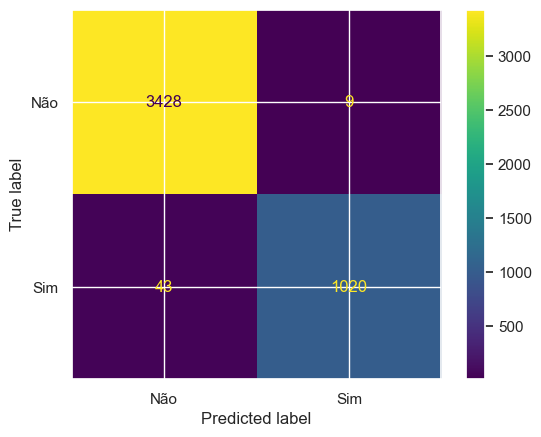

In [95]:
conf_matx_random = confusion_matrix(y_teste, y_pred_Rand_Frt)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matx_random, display_labels=["Não", "Sim"])
disp.plot()
plt.show()

##### Feature Importance

Até o momento, o **Random Forest** foi o **modelo mais performático**. Vamos tentar entender o processo de decisão e a importância dos atributos usados internamente, explorando algumas estratégias para avaliar a **contribuição dos campos** no dataset nesse modelo.

In [96]:
featrure_importance = modeloRandomForest.feature_importances_

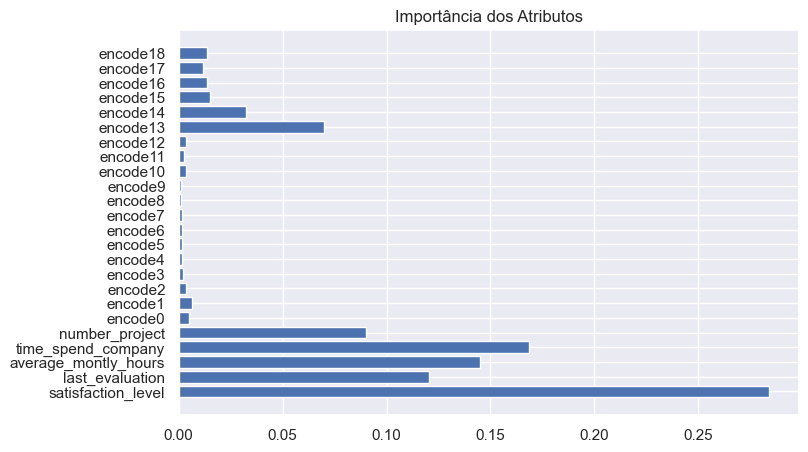

In [97]:
plt.figure(figsize=(8,5))
plt.title("Importância dos Atributos")
plt.barh(range(len(featrure_importance)), featrure_importance, color="b", align="center", linestyle="solid")
plt.yticks(range(len(featrure_importance)), colunas_dataset)
plt.show()


Os 6 atributos de maior importância são, em ordem decrescente: satisfaction_level, time_spend_company, average_montly_hours, last_evaluation, encode13 e encode14 (os dois últimos são Encodes, tudo indica, derivados de Number_Project).

Portanto, o Classificador utiliza principalmente o nível de satisfação, tempo de casa, carga horária, última avaliação e número de projetos para prever o turnover do funcionário.


#### 4.2.7 - DecisionTree

Para concluir a rodada de algoritmos clássicos de ML, o DecisionTree.

In [98]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
%matplotlib inline

def Decision_tree(max_depth_arg=None, min_sample_leaf_arg=2):
    modelo_dtree = DecisionTreeClassifier(max_depth = max_depth_arg, min_samples_leaf=min_sample_leaf_arg, random_state=10).fit(X_treino, y_treino)
    predicao_dtree = modelo_dtree.predict(X_teste)
    imprime_acuracia(predicao_dtree, y_teste)
    return modelo_dtree

In [99]:
mod_tree1 = Decision_tree()

Acurácia: 97.35555555555555 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3437
           1       0.95      0.94      0.94      1063

    accuracy                           0.97      4500
   macro avg       0.97      0.96      0.96      4500
weighted avg       0.97      0.97      0.97      4500



Já tivemos métricas melhores. Vamos ver se é possível aumentar a performance, pois não exploramos alterações nos hiperparâmetros.
Olhar o gráfico de tomada de decisão do modelo pode revelar comportamentos do modelo. 

Ajustar a profunidade da árvore ou a quantidade de exemplos no split são técnicas que podem melhorar o resultado, entretanto, é preciso equilibrar esse valor pois uma árvore muito profunda aumenta a chance de overfiting visto que ela irá tentar realizar o split otimizando os pontos de corte e não queremos um aprendizado excessivo dos dados de treino.


In [100]:
# Max_depth e Min_Sample_Leaf
mod_tree2 = Decision_tree(min_sample_leaf_arg=5)

Acurácia: 97.44444444444444 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      3437
           1       0.95      0.94      0.95      1063

    accuracy                           0.97      4500
   macro avg       0.97      0.96      0.96      4500
weighted avg       0.97      0.97      0.97      4500



In [101]:
mod_tree3 = Decision_tree(max_depth_arg=10)

Acurácia: 97.66666666666667 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      3437
           1       0.97      0.93      0.95      1063

    accuracy                           0.98      4500
   macro avg       0.97      0.96      0.97      4500
weighted avg       0.98      0.98      0.98      4500



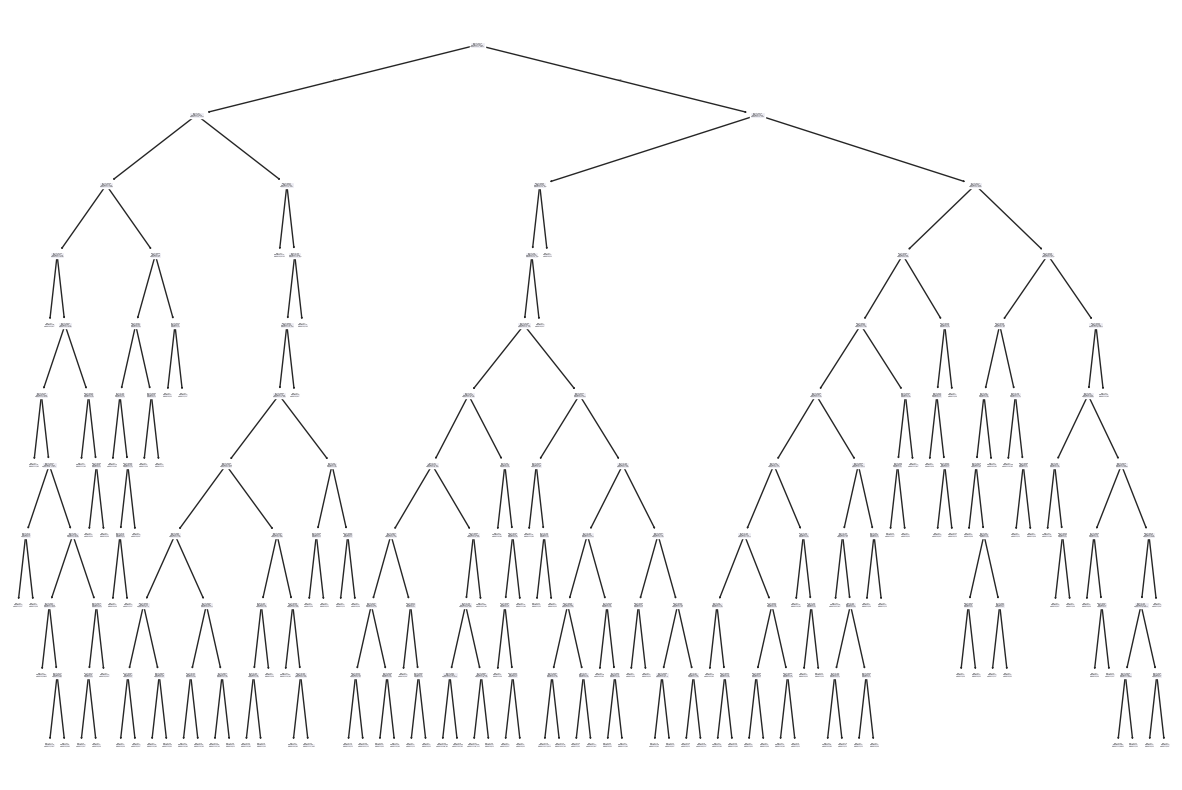

In [102]:
plt.figure(figsize=(15, 10))
plot_tree(mod_tree3)
plt.show()

#### 4.2.8 - Combinação de Algoritmos - Ensembles


In [103]:
def get_ensembles():
    ensembles = {}
    ensembles['lr'] = LogisticRegression()
    ensembles['knn'] = KNeighborsClassifier()
    ensembles['dtreec'] = DecisionTreeClassifier()
    ensembles['svm'] = SVC()
    ensembles['bayes'] = GaussianNB()
    return ensembles

def evaluate_model(model, X, y):
    cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cross_validation, n_jobs=-1)
    return scores



#### Avaliação Individual dos algoritmos

In [104]:
from sklearn import ensemble
from numpy import std
ensembles = get_ensembles()
results, names = list(), list()

for name, ensemble in ensembles.items():
    # evaluate model
    scores = evaluate_model(ensemble, X_treino, y_treino)
    # store results
    results.append(scores)
    names.append(name)
    # summarize results
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>lr 0.860 (0.009)
>knn 0.942 (0.007)
>dtreec 0.977 (0.004)
>svm 0.938 (0.007)
>bayes 0.805 (0.009)


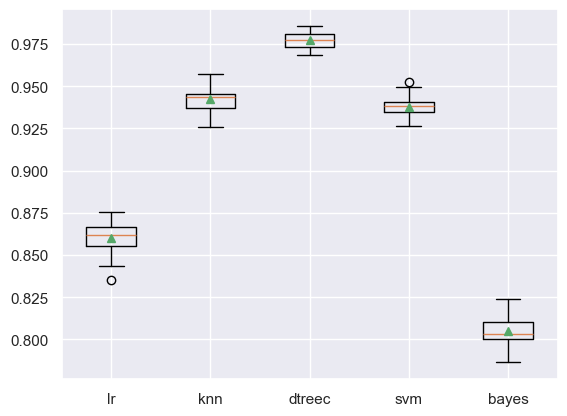

In [105]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [106]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

def get_stacking():
    level0 = list()
    level0.append(("lr", LogisticRegression()))
    level0.append(("knn", KNeighborsClassifier()))
    level0.append(("cart", DecisionTreeClassifier()))
    level0.append(("svm", SVC()))
    level0.append(("bayes", GaussianNB()))

    #Meta Learner
    level1 = LogisticRegression()
    
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model 

In [107]:
ens_model = get_stacking()
ens_model.fit(X_treino, y_treino)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('knn', KNeighborsClassifier()),
                               ('cart', DecisionTreeClassifier()),
                               ('svm', SVC()), ('bayes', GaussianNB())],
                   final_estimator=LogisticRegression())

In [108]:
pred_ens = ens_model.predict(X_teste)
imprime_acuracia(pred_ens, y_teste)

Acurácia: 98.0 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3437
           1       0.95      0.96      0.96      1063

    accuracy                           0.98      4500
   macro avg       0.97      0.97      0.97      4500
weighted avg       0.98      0.98      0.98      4500



Conseguimos melhorar a métrica do Decision Tree, mas as do **Random Forest Classifier** se mantiveram melhores.

Até aqui trabalhamos com algoritmos clássicos de Machine Learning para a criação de modelos preditivos. Utilizamos todas os atributos do conjunto de dados e as otimizações feitas foram testadas com a combinação de parâmetros diferentes em várias rodadas (Grid Search).

Apesar de termos conseguido obter preformances com acurácia e f1-score superiores a 98%, existe outra técnica que envolve a criação de uma Rede Neural profunda (Deep Learning). É muito poderosa, embora seja mais eficaz com grandes quantidades de amostras.

#### 4.2.8 - Neural Network

Montagem da arquitetura da Rede

In [109]:
modelo_neural = tf.keras.models.Sequential()
modelo_neural.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(24,)))
modelo_neural.add(tf.keras.layers.Dense(units=128, activation='relu'))
modelo_neural.add(tf.keras.layers.Dropout(0.05))
modelo_neural.add(tf.keras.layers.Dense(units=128, activation='relu'))
modelo_neural.add(tf.keras.layers.Dense(units=64, activation='relu'))
modelo_neural.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [110]:
modelo_neural.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,545 (174.00 KB)

 Trainable params: 44,545 (174.00 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
modelo_neural.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

In [112]:
epochs = modelo_neural.fit(X_treino, y_treino, epochs=100, batch_size=50)

Epoch 1/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7422 - loss: 0.5829
Epoch 2/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8571 - loss: 0.3611
Epoch 3/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8843 - loss: 0.2771
Epoch 4/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9034 - loss: 0.2442
Epoch 5/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.9178 - loss: 0.2163
Epoch 6/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9301 - loss: 0.2024
Epoch 7/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9330 - loss: 0.1893
Epoch 8/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9398 - loss: 0.1817  
Epoch 9/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9429 - loss: 0.1791
Epoch 10/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.9479 - loss: 0.1648
Epoch 11/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9502 - loss: 0.1641
Epoch 12/100
210/210 ━━━━━━━━━━━━━━

In [113]:
y_pred_neural = modelo_neural.predict(X_teste)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step


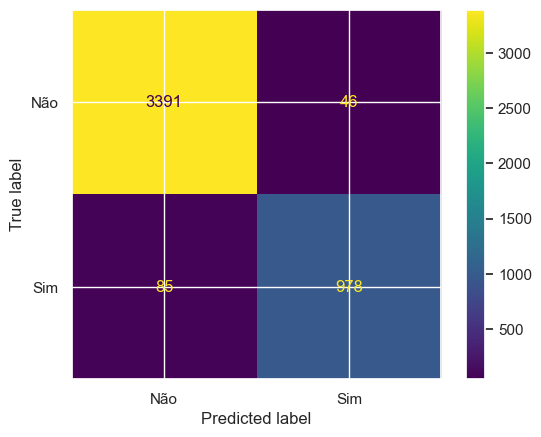

In [114]:
conf_matx_neural = confusion_matrix(y_teste, y_pred_neural > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matx_neural, display_labels=["Não", "Sim"])
disp.plot()
plt.show()

In [115]:
imprime_acuracia(y_pred_neural>0.7, y_teste)

Acurácia: 96.97777777777777 %
Relatorio sw Classificacao: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      3437
           1       0.97      0.90      0.93      1063

    accuracy                           0.97      4500
   macro avg       0.97      0.95      0.96      4500
weighted avg       0.97      0.97      0.97      4500



Vários hiperparâmetros foram alterados, assim como a arquitetura da rede, para melhorar a performance de acerto e os valores atuais do algoritmo foram testados junto com outras, mas essas foram as melhores métricas obtidas.

### 5 - Considerações
O fato de termos conseguido uma acurácia de quase 99% com o Random Forest é bastante animador, mas ainda poderíamos evoluir algumas questões: nossa função é atender a uma necessidade de negócio e trazer insights para revelar aspectos dos dados que apoiem decisões. 

O Random Forest Classifier revelou em seu treinamento, por ordem de importância, as seguintes características com maior contribuição no processo de classificação:

 - Nível de satisfação 
 - Tempo de casa
 - Carga horária
 - última avaliação 
 - número de projetos

É importante dizer que para associar essas características com as causas das decisões dos colaboradores, é preciso avançar mais especificamente em determinadas análises. 

Curiosamente, o salário não ficou nem entre os 5 primeiros atributos. Entretanto, o Nível de Satisfação "ofusca" causas reais, uma vez que é uma característica que agrega opinião sobre vários aspectos da empresa, inclusive aqueles que nem estão representados no dataset.


#### 5.1 - Performance dos Modelos
```
Método             Acurácia
Linear Regression: 86.51
KNN:               96.24
SVM:               96.56
XGBoost:           98,87
Random Forest:     99.18
Rede Neural:       96.97
DecisionTree       97,66
Ensembles          98.00
```

#### 5.2 - Análise
Acreditamos que taxas de acerto como as que encontramos são um ótimo resultado no nosso trabalho.

Embora uma grande quantidade de registros e características verdadeiramente representativas da realidade estudada sejam o melhor insumo para modelos preditivos, precisamos ter em mente que nesse caso ela depende diretamente do tamanho da empresa e do tempo.

Caso a performance apresentada fosse insatisfatória, teríamos como alternativas:
- Continuar avaliando e alterando os hiperparâmetros dos algorítimos, dentro de uma certa margem;
- Procurar algorítimos mais interessantes para esse cenário, com maior ou menor complexidade e/ou flexibilidade;
- Reunir mais amostras de treinamento
- Reunir mais atributos ao conjunto de dados, possivelmente de outras fontes


Além disso, se acontecer mudanças no processo de negócio / ambiente da empresa existe o potencial de que o perfil dos dados treinados muito provavelmente afetará os resultados requerendo uma recalibragem de parte do processo.

Para otimizar nosso investimento de recursos em datascience, uma passo a mais é necessário: o monitoramento e acompanhamento de diversos aspectos desse engenho.

---

#### 5.3 - Publicando o Modelo Preditivo

O trabalho ainda não acabou. Precisamos disponibilizar uma aplicação que, recebendo novos dados de entrada, avalie e faça a previsão. Para isso, teremos que considerar os seguintes pontos:

**1 - Exportar o Modelo**:
Para um formato compatível com a linguagem de programação que planejamos usar para criar uma API (serviço que se comunica com a aplicação).

**2 - Configurar um Ambiente de Implantação**:
Local para hospedar seu modelo e sua aplicação (são duas coisas distintas). Por exemplo, ambientes em nuvem como a AWS (Amazon Web Services), Azure (Microsoft Azure), Google Cloud Platform, etc.

**3 - Criar uma API**:
Criar uma API que possa receber solicitações da aplicação para o modelo preditvo exportado e enviar de volta a predição.

**4 - Integrar o Modelo na API**:
Carregar o modelo treinado em nossa API e configurar um endpoint (um serviço de integração) para permitir a comunicação entre a Aplicação e o Modelo. Quando a API receber dados de entrada da aplicação, ela deve usar o modelo para gerar previsões e enviar as previsões de volta como resposta.

**5 - Testar a Implantação**:
Realizar testes para garantir que a API esteja funcionando corretamente. 

**6 - Compliance  e Aderência à LGPD/GDPR**:
Certificar-se de estar em conformidade com as leis de proteção de dados ao lidar com dados pessoais ou sensíveis / estratégicos da instituição.

**7 - Segurança**:
Implementar medidas de segurança adequadas, como autenticação e autorização, para proteger sua API e dados.

**8 - Monitoria**:
Manter acompanhamento automatizado sobre a performance do modelo, dentro da expectativa.

### 6 - Exportação do Modelo Selecionado

Exportaremos o **Randon Forest** por ser um modelo bastante popular

In [116]:
import joblib

In [117]:
joblib.dump(modeloRandomForest, 'modeloRandomForest.pkl')

['modeloRandomForest.pkl']

Não devemos esquecer que os dados que foram submetidos à predição foram pré-processados e isso precisa ser feito de forma idêntica ao dado que será submetido ao modelo preditivo publicado.

É possível "empacotar" esse processo em um "pipeline", salvá-lo e exportá-lo também. 

Salvamos os Encoders _One Hot_ e a Normalização com _Min Max_ que utilizaremos no ambiente de produção. O acesso ao site de simulação pode ser feito neste link: [Em breve](http://127.0.0.1/app/turnover)